In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
import os
import boto3
import io
from dotenv import load_dotenv

load_dotenv()

# retrieve credentials from env
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region_name = os.getenv('AWS_REGION')
bucket_name = os.getenv('BUCKET_NAME')
file_key = os.getenv('FILE_KEY')

# create s3 client
s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key_id,
                  aws_secret_access_key=aws_secret_access_key,
                  region_name=region_name)

# fetch file from s3 bucket
response = s3.get_object(Bucket=bucket_name, Key=file_key)
data = pd.read_csv(io.BytesIO(response['Body'].read()))

In [9]:
display(data.head())
print(data.shape)
data.info()

Transaction ID                           Customer ID  \
0  15d2e414-8735-46fc-9e02-80b472b2580f  d1b87f62-51b2-493b-ad6a-77e0fe13e785   
1  0bfee1a0-6d5e-40da-a446-d04e73b1b177  37de64d5-e901-4a56-9ea0-af0c24c069cf   
2  e588eef4-b754-468e-9d90-d0e0abfc1af0  1bac88d6-4b22-409a-a06b-425119c57225   
3  4de46e52-60c3-49d9-be39-636681009789  2357c76e-9253-4ceb-b44e-ef4b71cb7d4d   
4  074a76de-fe2d-443e-a00c-f044cdb68e21  45071bc5-9588-43ea-8093-023caec8ea1c   

   Transaction Amount     Transaction Date Payment Method Product Category  \
0               58.09  2024-02-20 05:58:41  bank transfer      electronics   
1              389.96  2024-02-25 08:09:45     debit card      electronics   
2              134.19  2024-03-18 03:42:55         PayPal    home & garden   
3              226.17  2024-03-16 20:41:31  bank transfer         clothing   
4              121.53  2024-01-15 05:08:17  bank transfer         clothing   

   Quantity  Customer Age Customer Location Device Used       IP Address  \
0         1            17     Amandaborough      tablet   212.195.49.198   
1         2            40      East Timothy     desktop  208.106.249.121   
2         2            22        Davismouth      tablet     76.63.88.212   
3         5            31          Lynnberg     desktop   207.208.171.73   
4         2            51      South Nicole      tablet   190.172.14.169   

                                    Shipping Address  \
0                   Unit 8934 Box 0058\nDPO AA 05437   
1            634 May Keys\nPort Cherylview, NV 75063   
2    16282 Dana Falls Suite 790\nRothhaven, IL 15564   
3     828 Strong Loaf Apt. 646\nNew Joshua, UT 84798   
4  29799 Jason Hills Apt. 439\nWest Richardtown, ...   

                                     Billing Address  Is Fraudulent  \
0                   Unit 8934 Box 0058\nDPO AA 05437              0   
1            634 May Keys\nPort Cherylview, NV 75063              0   
2    16282 Dana Falls Suite 790\nRothhaven, IL 15564              0   
3     828 Strong Loaf Apt. 646\nNew Joshua, UT 84798              0   
4  29799 Jason Hills Apt. 439\nWest Richardtown, ...              0   

   Account Age Days  Transaction Hour  
0                30                 5  
1                72                 8  
2                63                 3  
3               124                20  
4               158                 5

(1472952, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  T

# Cleaning data columns before splitting

#### Cleaning Customer Age


In [10]:
# removinng rows with customer age less than 12
data = data[data['Customer Age'] > 12].reset_index(drop=True) 

data['Parent_Assisted_Purchase'] = ((data['Customer Age'] > 12) &
                                    (data['Customer Age'] < 16)).astype(int)

#### Creating age groups

In [11]:
def age_groups(x):
    if x < 20:
        return 0
    elif 20 <= x <= 29:
        return 1
    elif 30 <= x <= 39:
        return 2
    elif 40 <= x <= 49:
        return 3
    elif 50 <= x <= 59:
        return 4
    else:
        return 5

data['Age Group'] = data['Customer Age'].apply(age_groups)

#### Cleaning date

In [12]:
data["Transaction Date"] = pd.to_datetime(data["Transaction Date"])
data['Transaction Day'] = data["Transaction Date"].dt.day.astype(int)
data["Transaction Day of Week"] = data["Transaction Date"].dt.day_of_week.astype(int)
data["Transaction Month"] = data["Transaction Date"].dt.month.astype(int)

#### Creating time of day groups

In [13]:
def time_of_day_groups(x):
    if x < 6:
        return 0
    elif 6 <= x <= 11:
        return 1
    elif 12 <= x <= 17:
        return 2
    else:
        return 3

data['Time of Day'] = data['Transaction Hour'].apply(time_of_day_groups)

#### Creating isAddressMatched feature

In [14]:
data['isAddressMatched'] = (data["Shipping Address"] == data["Billing Address"]).astype(int)

#### Creating Price per product feature

In [15]:
data['Price per product'] = data['Transaction Amount'] / data['Quantity']

#### Creating one-hot encoded features for categorical features

In [16]:
encoder = OneHotEncoder(sparse_output=False)
features = ['Time of Day', 'Age Group', 'Payment Method', 'Product Category', 'Device Used', 'Transaction Month', 'Transaction Day of Week']
encoded_features = encoder.fit_transform(data[features])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(features))
encoded_data.head()

final_data = pd.concat([data, encoded_data], axis=1 )

#### Final cleaned data before splitting

In [17]:
display(final_data.head())
print(final_data.shape)
display(final_data.info())

Transaction ID                           Customer ID  \
0  15d2e414-8735-46fc-9e02-80b472b2580f  d1b87f62-51b2-493b-ad6a-77e0fe13e785   
1  0bfee1a0-6d5e-40da-a446-d04e73b1b177  37de64d5-e901-4a56-9ea0-af0c24c069cf   
2  e588eef4-b754-468e-9d90-d0e0abfc1af0  1bac88d6-4b22-409a-a06b-425119c57225   
3  4de46e52-60c3-49d9-be39-636681009789  2357c76e-9253-4ceb-b44e-ef4b71cb7d4d   
4  074a76de-fe2d-443e-a00c-f044cdb68e21  45071bc5-9588-43ea-8093-023caec8ea1c   

   Transaction Amount    Transaction Date Payment Method Product Category  \
0               58.09 2024-02-20 05:58:41  bank transfer      electronics   
1              389.96 2024-02-25 08:09:45     debit card      electronics   
2              134.19 2024-03-18 03:42:55         PayPal    home & garden   
3              226.17 2024-03-16 20:41:31  bank transfer         clothing   
4              121.53 2024-01-15 05:08:17  bank transfer         clothing   

   Quantity  Customer Age Customer Location Device Used       IP Address  \
0         1            17     Amandaborough      tablet   212.195.49.198   
1         2            40      East Timothy     desktop  208.106.249.121   
2         2            22        Davismouth      tablet     76.63.88.212   
3         5            31          Lynnberg     desktop   207.208.171.73   
4         2            51      South Nicole      tablet   190.172.14.169   

                                    Shipping Address  \
0                   Unit 8934 Box 0058\nDPO AA 05437   
1            634 May Keys\nPort Cherylview, NV 75063   
2    16282 Dana Falls Suite 790\nRothhaven, IL 15564   
3     828 Strong Loaf Apt. 646\nNew Joshua, UT 84798   
4  29799 Jason Hills Apt. 439\nWest Richardtown, ...   

                                     Billing Address  Is Fraudulent  \
0                   Unit 8934 Box 0058\nDPO AA 05437              0   
1            634 May Keys\nPort Cherylview, NV 75063              0   
2    16282 Dana Falls Suite 790\nRothhaven, IL 15564              0   
3     828 Strong Loaf Apt. 646\nNew Joshua, UT 84798              0   
4  29799 Jason Hills Apt. 439\nWest Richardtown, ...              0   

   Account Age Days  Transaction Hour  Parent_Assisted_Purchase  Age Group  \
0                30                 5                         0          0   
1                72                 8                         0          3   
2                63                 3                         0          1   
3               124                20                         0          2   
4               158                 5                         0          4   

   Transaction Day  Transaction Day of Week  Transaction Month  Time of Day  \
0               20                        1                  2            0   
1               25                        6                  2            1   
2               18                        0                  3            0   
3               16                        5                  3            3   
4               15                        0                  1            0   

   isAddressMatched  Price per product  Time of Day_0  Time of Day_1  \
0                 1             58.090            1.0            0.0   
1                 1            194.980            0.0            1.0   
2                 1             67.095            1.0            0.0   
3                 1             45.234            0.0            0.0   
4                 1             60.765            1.0            0.0   

   Time of Day_2  Time of Day_3  Age Group_0  Age Group_1  Age Group_2  \
0            0.0            0.0          1.0          0.0          0.0   
1            0.0            0.0          0.0          0.0          0.0   
2            0.0            0.0          0.0          1.0          0.0   
3            0.0            1.0          0.0          0.0          1.0   
4            0.0            0.0          0.0          0.0          0.0   

   Age Group_3  Age Group_4  Age

(1452549, 57)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452549 entries, 0 to 1452548
Data columns (total 57 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   Transaction ID                    1452549 non-null  object        
 1   Customer ID                       1452549 non-null  object        
 2   Transaction Amount                1452549 non-null  float64       
 3   Transaction Date                  1452549 non-null  datetime64[ns]
 4   Payment Method                    1452549 non-null  object        
 5   Product Category                  1452549 non-null  object        
 6   Quantity                          1452549 non-null  int64         
 7   Customer Age                      1452549 non-null  int64         
 8   Customer Location                 1452549 non-null  object        
 9   Device Used                       1452549 non-null  object        
 10  IP A

None

# Splitting, scaling, oversampling and cleaning

#### Splitting the data into 70/15/15

In [18]:
# Separate features and target
X = final_data.drop(columns=['Is Fraudulent'])  
y = final_data['Is Fraudulent']

# split into train (70%) and temp (30% for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# split temp into validation (15% of total) and test (15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# combine features and target into single DataFrames
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# check sizes
print(f"Train set: {train.shape}")
print(f"Validation set: {val.shape}")
print(f"Test set: {test.shape}")

Train set: (1016784, 57)
Validation set: (217882, 57)
Test set: (217883, 57)


In [19]:
train.describe().T

count                           mean  \
Transaction Amount                1016784.0                     226.927384   
Transaction Date                    1016784  2024-02-16 16:30:08.490307072   
Quantity                          1016784.0                         3.0009   
Customer Age                      1016784.0                      34.866896   
Account Age Days                  1016784.0                      179.63958   
Transaction Hour                  1016784.0                      11.285373   
Parent_Assisted_Purchase          1016784.0                       0.015178   
Age Group                         1016784.0                        2.03505   
Transaction Day                   1016784.0                      15.336134   
Transaction Day of Week           1016784.0                       2.945845   
Transaction Month                 1016784.0                        2.05058   
Time of Day                       1016784.0                       1.465045   
isAddressMatched                  1016784.0                       0.899537   
Price per product                 1016784.0                     103.703032   
Time of Day_0                     1016784.0                       0.266946   
Time of Day_1                     1016784.0                        0.24492   
Time of Day_2                     1016784.0                       0.244278   
Time of Day_3                     1016784.0                       0.243856   
Age Group_0                       1016784.0                       0.053806   
Age Group_1                       1016784.0                       0.244541   
Age Group_2                       1016784.0                       0.388536   
Age Group_3                       1016784.0                       0.245319   
Age Group_4                       1016784.0                       0.061514   
Age Group_5                       1016784.0                       0.006286   
Payment Method_PayPal             1016784.0                       0.249401   
Payment Method_bank transfer      1016784.0                       0.250247   
Payment Method_credit card        1016784.0                       0.250171   
Payment Method_debit card         1016784.0                       0.250181   
Product Category_clothing         1016784.0                       0.200021   
Product Category_electronics      1016784.0                       0.200359   
Product Category_health & beauty  1016784.0                       0.200423   
Product Category_home & garden    1016784.0                       0.199308   
Product Category_toys & games     1016784.0                       0.199889   
Device Used_desktop               1016784.0                       0.333113   
Device Used_mobile                1016784.0                       0.333775   
Device Used_tablet                1016784.0                       0.333112   
Transaction Month_1               1016784.0                       0.332075   
Transaction Month_2               1016784.0                       0.310383   
Transaction Month_3               1016784.0                       0.332429   
Transaction Month_4               1016784.0                       0.025113   
Transaction Day of Week_0         1016784.0                        0.14931   
Transaction Day of Week_1         1016784.0                       0.150121   
Transaction Day of Week_2         1016784.0                       0.143069   
Transaction Day of Week_3         1016784.0                        0.13907   
Transaction Day of Week_4         1016784.0                       0.139317   
Transaction Day of Week_5         1016784.0                        0.13957   
Transaction Day of Week_6         1016784.0                       0.139543   
Is Fraudulent                     1016784.0                       0.050126   

                                                  min  \
Transaction Amount                               10.0   
Transaction Date                  2024-01-01 00:00:00   
Quantity                                    

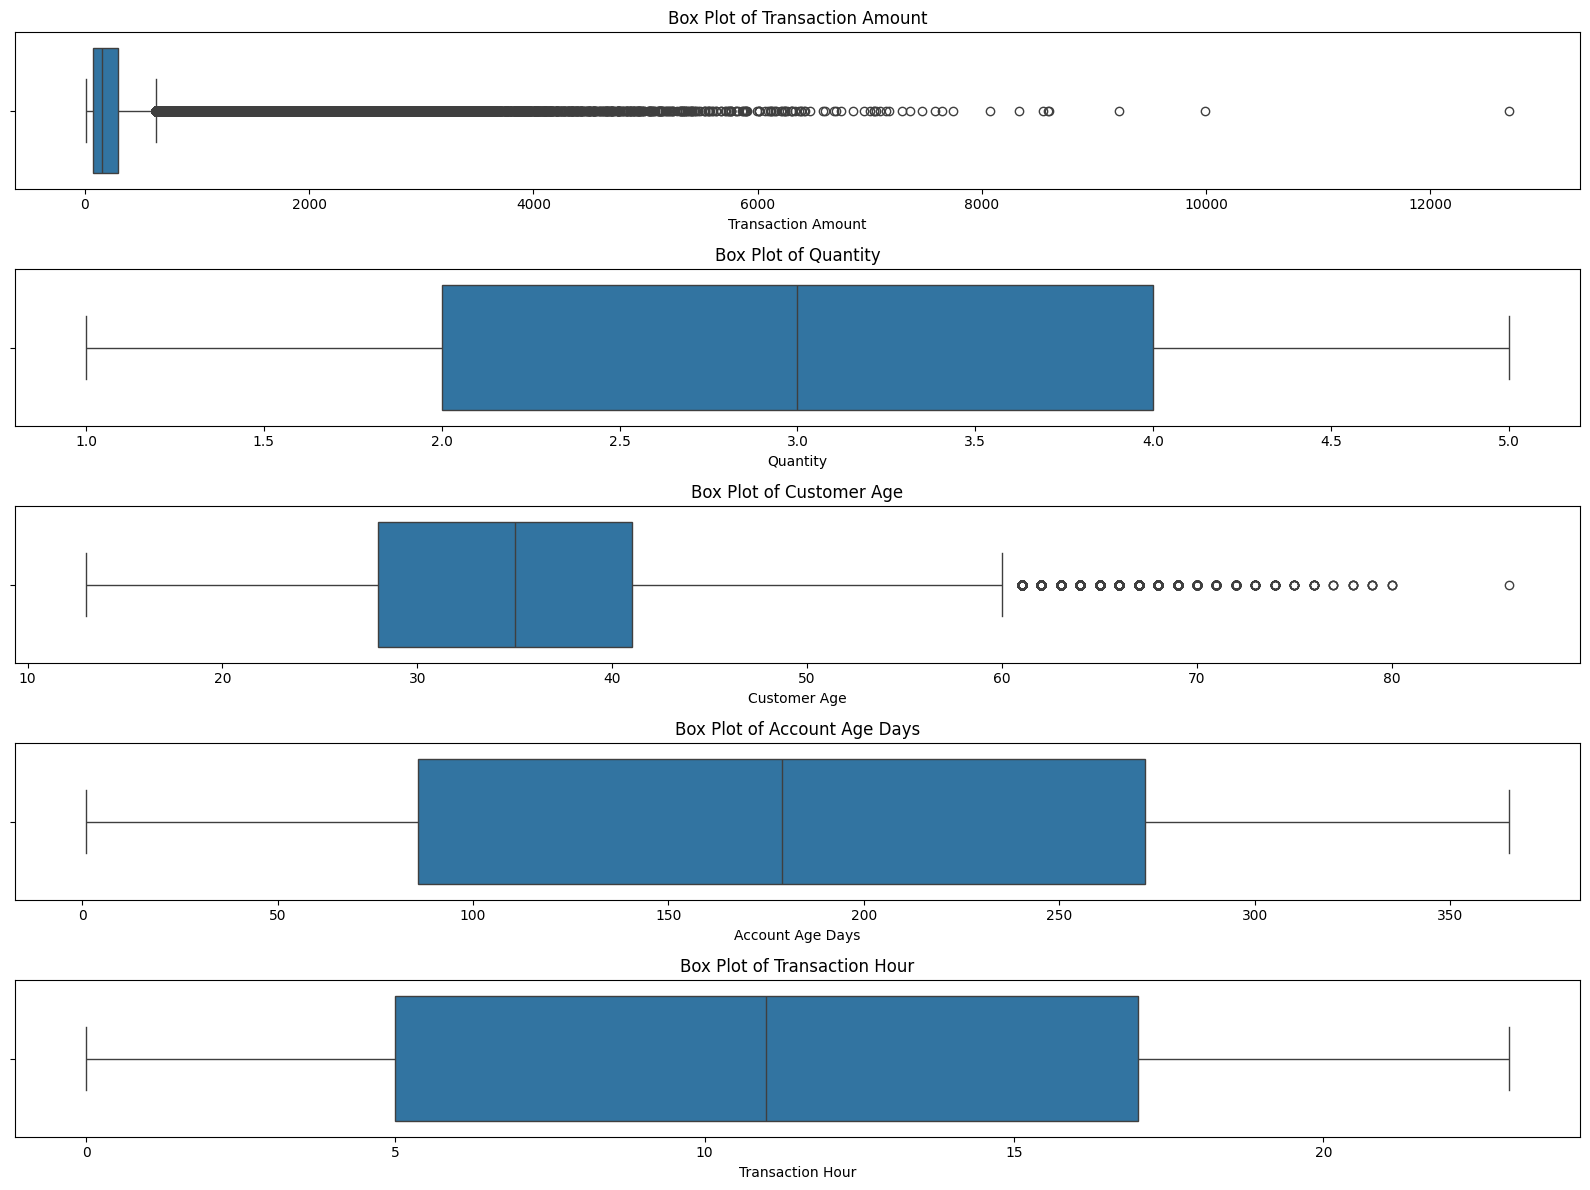

In [20]:
features = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=feature, data=train, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

#### Cleaning '*Customer Location*' feature

In [21]:
import category_encoders as ce

# fit target encoder on the training set
target_encoder = ce.TargetEncoder(cols=['Customer Location'])
train['custLocEncoded'] = target_encoder.fit_transform(train['Customer Location'], train['Is Fraudulent'])

# apply fitted target encoder on the validation and test sets
val['custLocEncoded'] = target_encoder.transform(val['Customer Location'])
test['custLocEncoded'] = target_encoder.transform(test['Customer Location'])

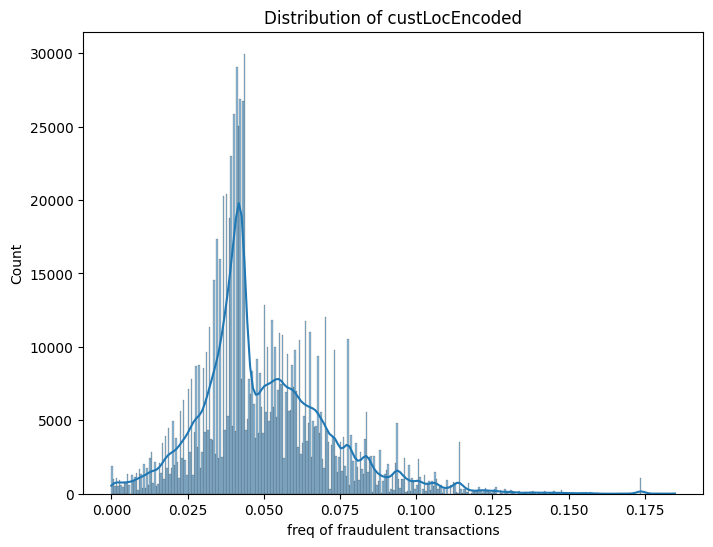

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(train['custLocEncoded'], kde=True)
plt.xlabel('freq of fraudulent transactions')
plt.ylabel('Count')
plt.title('Distribution of custLocEncoded')
plt.show()

### Oversampling

Dropping columns we don't need

In [23]:
train.drop(columns=[
                    'Transaction ID',
                    'Customer ID',
                    'Transaction Date',
                    'Payment Method',
                    'Product Category',
                    'Customer Location',
                    'Device Used',
                    'Shipping Address',
                    'Billing Address',
                    'IP Address',
                        ], inplace=True)

# do the same for val and test
val = val[train.columns]
test = test[train.columns]

train.head()

Transaction Amount  Quantity  Customer Age  Account Age Days  \
904466              108.85         4            41               342   
394104               24.90         5            24               155   
503616               18.20         4            22               237   
304747              366.46         1            29                85   
131498               25.79         2            27               133   

        Transaction Hour  Parent_Assisted_Purchase  Age Group  \
904466                23                         0          3   
394104                15                         0          1   
503616                16                         0          1   
304747                12                         0          1   
131498                 5                         0          1   

        Transaction Day  Transaction Day of Week  Transaction Month  \
904466               15                        3                  2   
394104               21                        3                  3   
503616               28                        6                  1   
304747               13                        5                  1   
131498               18                        6                  2   

        Time of Day  isAddressMatched  Price per product  Time of Day_0  \
904466            3                 1            27.2125            0.0   
394104            2                 1             4.9800            0.0   
503616            2                 1             4.5500            0.0   
304747            2                 1           366.4600            0.0   
131498            0                 0            12.8950            1.0   

        Time of Day_1  Time of Day_2  Time of Day_3  Age Group_0  Age Group_1  \
904466            0.0            0.0            1.0          0.0          0.0   
394104            0.0            1.0            0.0          0.0          1.0   
503616            0.0            1.0            0.0          0.0          1.0   
304747            0.0            1.0            0.0          0.0          1.0   
131498            0.0            0.0            0.0          0.0          1.0   

        Age Group_2  Age Group_3  Age Group_4  Age Group_5  \
904466          0.0          1.0          0.0          0.0   
394104          0.0          0.0          0.0          0.0   
503616          0.0          0.0          0.0          0.0   
304747          0.0          0.0          0.0          0.0   
131498          0.0          0.0          0.0          0.0   

        Payment Method_PayPal  Payment Method_bank transfer  \
904466                    1.0                           0.0   
394104                    0.0                           1.0   
503616                    1.0                           0.0   
304747                    0.0                           0.0   
131498                    0.0                           1.0   

        Payment Method_credit card  Payment Method_debit card  \
904466                         0.0                        0.0   
394104                         0.0                        0.0   
503616                         0.0                        0.0   
304747                         0.0                        1.0   
131498                         0.0                        0.0   

        Product Category_clothing  Product Category_electronics  \
904466                        0.0                           0.0   
394104                        0.0                           0.0   
503616                        0.0                           1.0   
304747                        0.0                           0.0   
131498                        1.0                           0.0   

        Product Category_health & beauty  Product Category_home & garden  \
904466                               0.0                             1.0   
394104                               0.0                             1.0   
503616                               0.0     

Oversampling using GAN

In [24]:
X_train = train.drop(columns=['Is Fraudulent'])
y_train = train['Is Fraudulent']

# split the training data into majority and minority classes
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

# ensure all columns in the minority class df are numeric
X_train_majority = X_train_majority.select_dtypes(include=[np.number])
X_train_minority = X_train_minority.select_dtypes(include=[np.number])

# def gan architecture
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        return self.network(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

# set params
latent_dim = 10
input_dim = X_train_majority.shape[1]
batch_size = 64
epochs = 1000
lr = 0.0002

# init gan
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# loss and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)

# convert data to pytorch tensors
X_minority = torch.tensor(X_train_minority.values, dtype=torch.float32)

# train gan
for epoch in range(epochs):
    # train discriminator
    real_data = X_minority[torch.randint(0, len(X_minority), (batch_size,))]
    fake_data = generator(torch.randn(batch_size, latent_dim))

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), real_labels)
    fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # train generator
    optimizer_g.zero_grad()
    generated_labels = torch.ones(batch_size, 1)  
    g_loss = criterion(discriminator(fake_data), generated_labels)
    g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# generate synthetic samples for the minority class
num_synthetic_samples = len(X_train_majority) - len(X_train_minority)
synthetic_samples = generator(torch.randn(num_synthetic_samples, latent_dim)).detach().numpy()

# df for synthetic data
synthetic_data = pd.DataFrame(synthetic_samples, columns=X_train_majority.columns)
synthetic_data['Is Fraudulent'] = 1  # Label synthetic samples as minority class

# concat synthetic data with original data
X_train_majority['Is Fraudulent'] = 0  
X_train_minority['Is Fraudulent'] = 1  
train_oversampled_GAN = pd.concat(
    [X_train_majority, X_train_minority, synthetic_data],
    axis=0
).reset_index(drop=True)

#check target class distribution
print("Original training set class distribution:")
print(y_train.value_counts())
print("\nOversampled training set class distribution:")
print(train_oversampled_GAN['Is Fraudulent'].value_counts())

print(train_oversampled_GAN.head())

print("Checking for NA rows in oversampled training set:")
print(train_oversampled_GAN[train_oversampled_GAN.isna().any(axis=1)])

Epoch 0/1000 | D Loss: 15.2697 | G Loss: 0.6910
Epoch 100/1000 | D Loss: 0.6826 | G Loss: 0.7524
Epoch 200/1000 | D Loss: 0.4072 | G Loss: 1.2036
Epoch 300/1000 | D Loss: 0.3816 | G Loss: 1.4188
Epoch 400/1000 | D Loss: 0.1829 | G Loss: 2.2956
Epoch 500/1000 | D Loss: 0.2143 | G Loss: 2.6265
Epoch 600/1000 | D Loss: 0.1757 | G Loss: 3.4152
Epoch 700/1000 | D Loss: 0.0863 | G Loss: 3.5409
Epoch 800/1000 | D Loss: 0.0797 | G Loss: 4.0811
Epoch 900/1000 | D Loss: 0.0485 | G Loss: 4.0927
Original training set class distribution:
Is Fraudulent
0    965817
1     50967
Name: count, dtype: int64

Oversampled training set class distribution:
Is Fraudulent
0    965817
1    965817
Name: count, dtype: int64
   Transaction Amount  Quantity  Customer Age  Account Age Days  \
0              108.85       4.0          41.0             342.0   
1               24.90       5.0          24.0             155.0   
2               18.20       4.0          22.0             237.0   
3              366.46      

Oversampling with SMOTE

In [25]:
# apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_oversampled_SMOTE, y_train_oversampled_SMOTE = smote.fit_resample(X_train, y_train)

# convert back to df 
train_oversampled_SMOTE = pd.DataFrame(X_train_oversampled_SMOTE, columns=X_train.columns)
train_oversampled_SMOTE['Is Fraudulent'] = y_train_oversampled_SMOTE

# check distribution of target class
print("Original training set class distribution:")
print(y_train.value_counts())
print("\nOversampled training set class distribution:")
print(y_train_oversampled_SMOTE.value_counts())

Original training set class distribution:
Is Fraudulent
0    965817
1     50967
Name: count, dtype: int64

Oversampled training set class distribution:
Is Fraudulent
0    965817
1    965817
Name: count, dtype: int64


### Scaling

#### Scaling Transaction Amount

In [26]:
# init scaler
scaler = StandardScaler()

train['Transaction Amount Rescaled'] = np.log10(train['Transaction Amount'])
train['Transaction Amount Rescaled'] = scaler.fit_transform(train[['Transaction Amount Rescaled']])

# apply the fitted scaler to the validation set
val['Transaction Amount Rescaled'] = np.log10(val['Transaction Amount'])
val['Transaction Amount Rescaled'] = scaler.transform(val[['Transaction Amount Rescaled']])

# apply the fitted scaler to the test set
test['Transaction Amount Rescaled'] = np.log10(test['Transaction Amount'])
test['Transaction Amount Rescaled'] = scaler.transform(test[['Transaction Amount Rescaled']])

# apply the fitted scaler to gan oversampled training set
train_oversampled_GAN['Transaction Amount Rescaled'] = np.log10(train_oversampled_GAN['Transaction Amount'])
train_oversampled_GAN['Transaction Amount Rescaled'] = scaler.transform(train_oversampled_GAN[['Transaction Amount Rescaled']])

# apply the fitted scaler to smote train_oversampled set
train_oversampled_SMOTE['Transaction Amount Rescaled'] = np.log10(train_oversampled_SMOTE['Transaction Amount'])
train_oversampled_SMOTE['Transaction Amount Rescaled'] = scaler.transform(train_oversampled_SMOTE[['Transaction Amount Rescaled']])


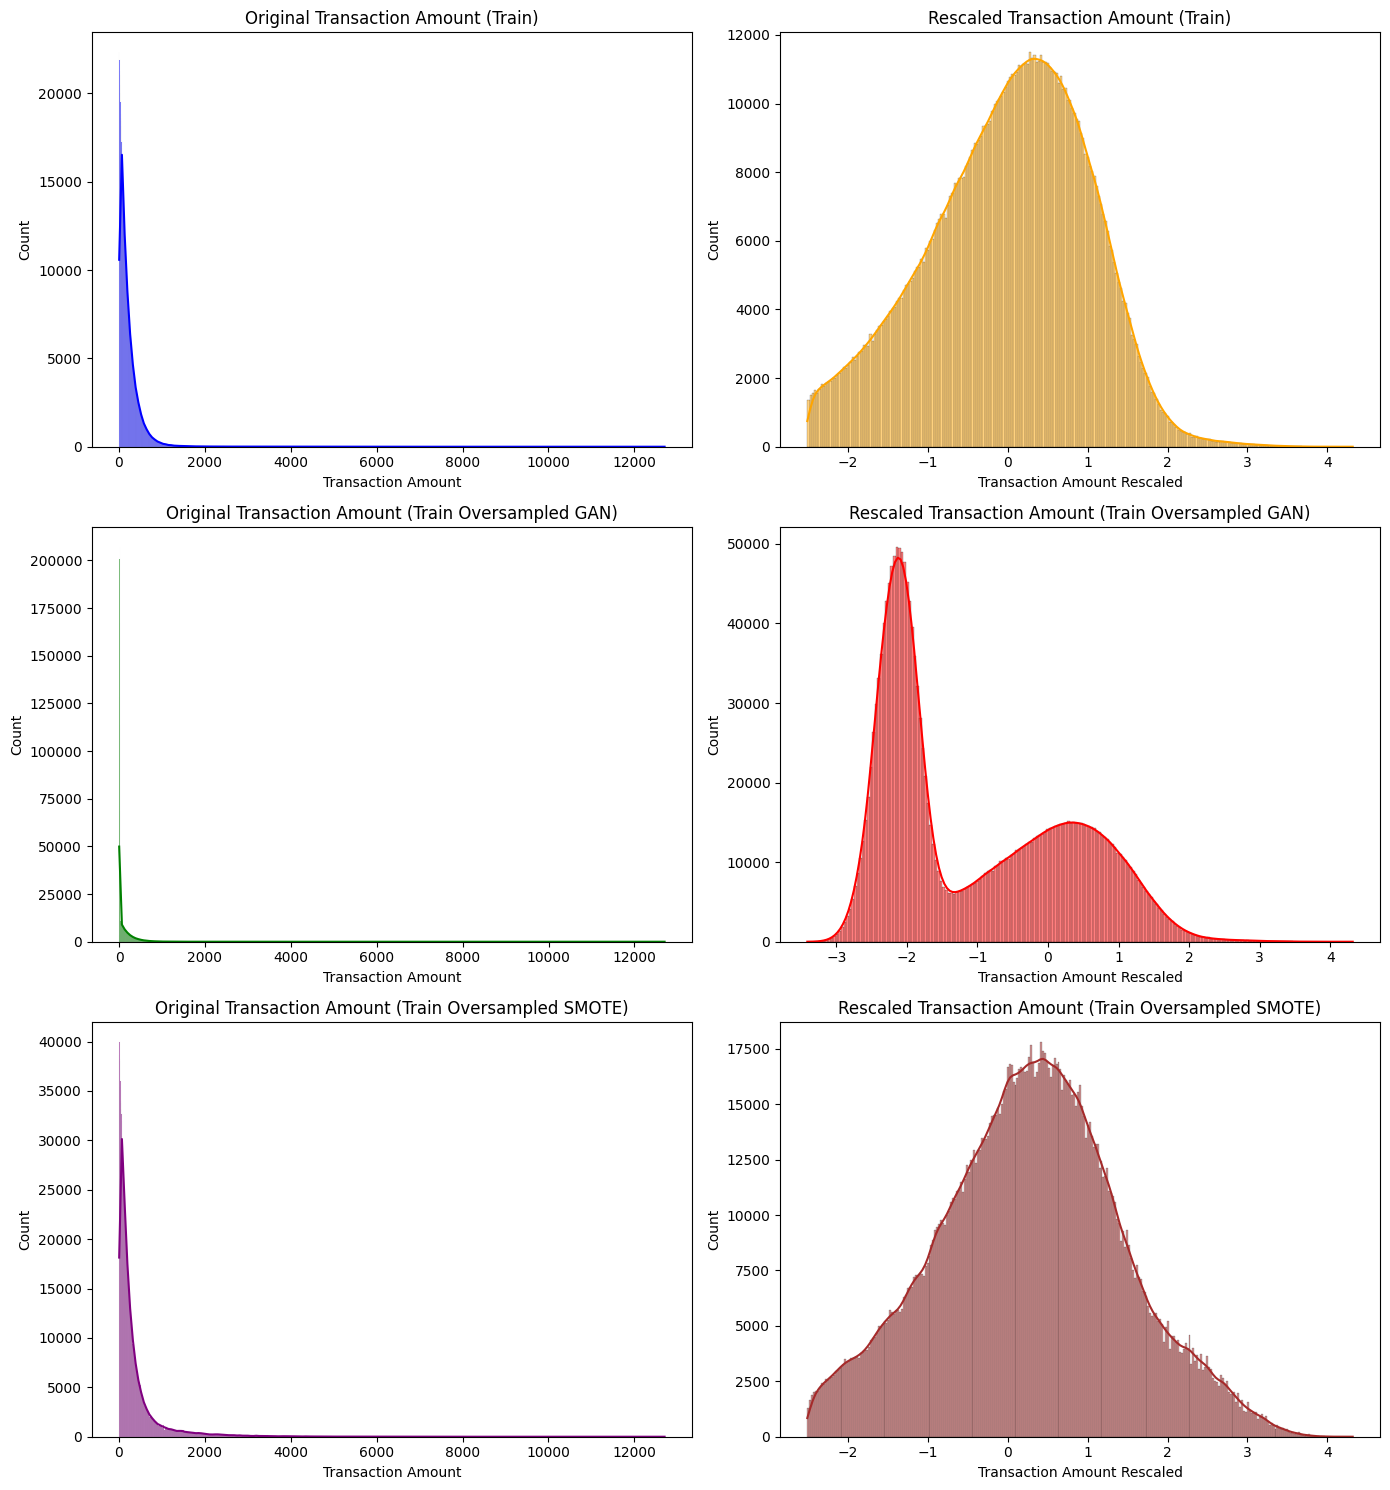

In [27]:
# plot comparison of original and rescaled Transaction Amount for the train set (original, gan, smote)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

sns.histplot(train['Transaction Amount'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Transaction Amount')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Original Transaction Amount (Train)')

sns.histplot(train['Transaction Amount Rescaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Transaction Amount Rescaled')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Rescaled Transaction Amount (Train)')

sns.histplot(train_oversampled_GAN['Transaction Amount'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Transaction Amount')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Original Transaction Amount (Train Oversampled GAN)')

sns.histplot(train_oversampled_GAN['Transaction Amount Rescaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Transaction Amount Rescaled')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Rescaled Transaction Amount (Train Oversampled GAN)')

sns.histplot(train_oversampled_SMOTE['Transaction Amount'], kde=True, color='purple', ax=axes[2, 0])
axes[2, 0].set_xlabel('Transaction Amount')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_title('Original Transaction Amount (Train Oversampled SMOTE)')

sns.histplot(train_oversampled_SMOTE['Transaction Amount Rescaled'], kde=True, color='brown', ax=axes[2, 1])
axes[2, 1].set_xlabel('Transaction Amount Rescaled')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Rescaled Transaction Amount (Train Oversampled SMOTE)')

plt.tight_layout()
plt.show()


#### Scaling Account Age

In [28]:
# same scaling for account age
scaler_account_age = StandardScaler()

train['Account Age Rescaled'] = np.log10(train['Account Age Days'])
train['Account Age Rescaled'] = scaler_account_age.fit_transform(train[['Account Age Rescaled']])

train_oversampled_GAN['Account Age Rescaled'] = np.log10(train_oversampled_GAN['Account Age Days'])
train_oversampled_GAN['Account Age Rescaled'] = scaler_account_age.transform(train_oversampled_GAN[['Account Age Rescaled']])

val['Account Age Rescaled'] = np.log10(val['Account Age Days'])
val['Account Age Rescaled'] = scaler_account_age.transform(val[['Account Age Rescaled']])

test['Account Age Rescaled'] = np.log10(test['Account Age Days'])
test['Account Age Rescaled'] = scaler_account_age.transform(test[['Account Age Rescaled']])

train_oversampled_SMOTE['Account Age Rescaled'] = np.log10(train_oversampled_SMOTE['Account Age Days'])
train_oversampled_SMOTE['Account Age Rescaled'] = scaler_account_age.transform(train_oversampled_SMOTE[['Account Age Rescaled']])


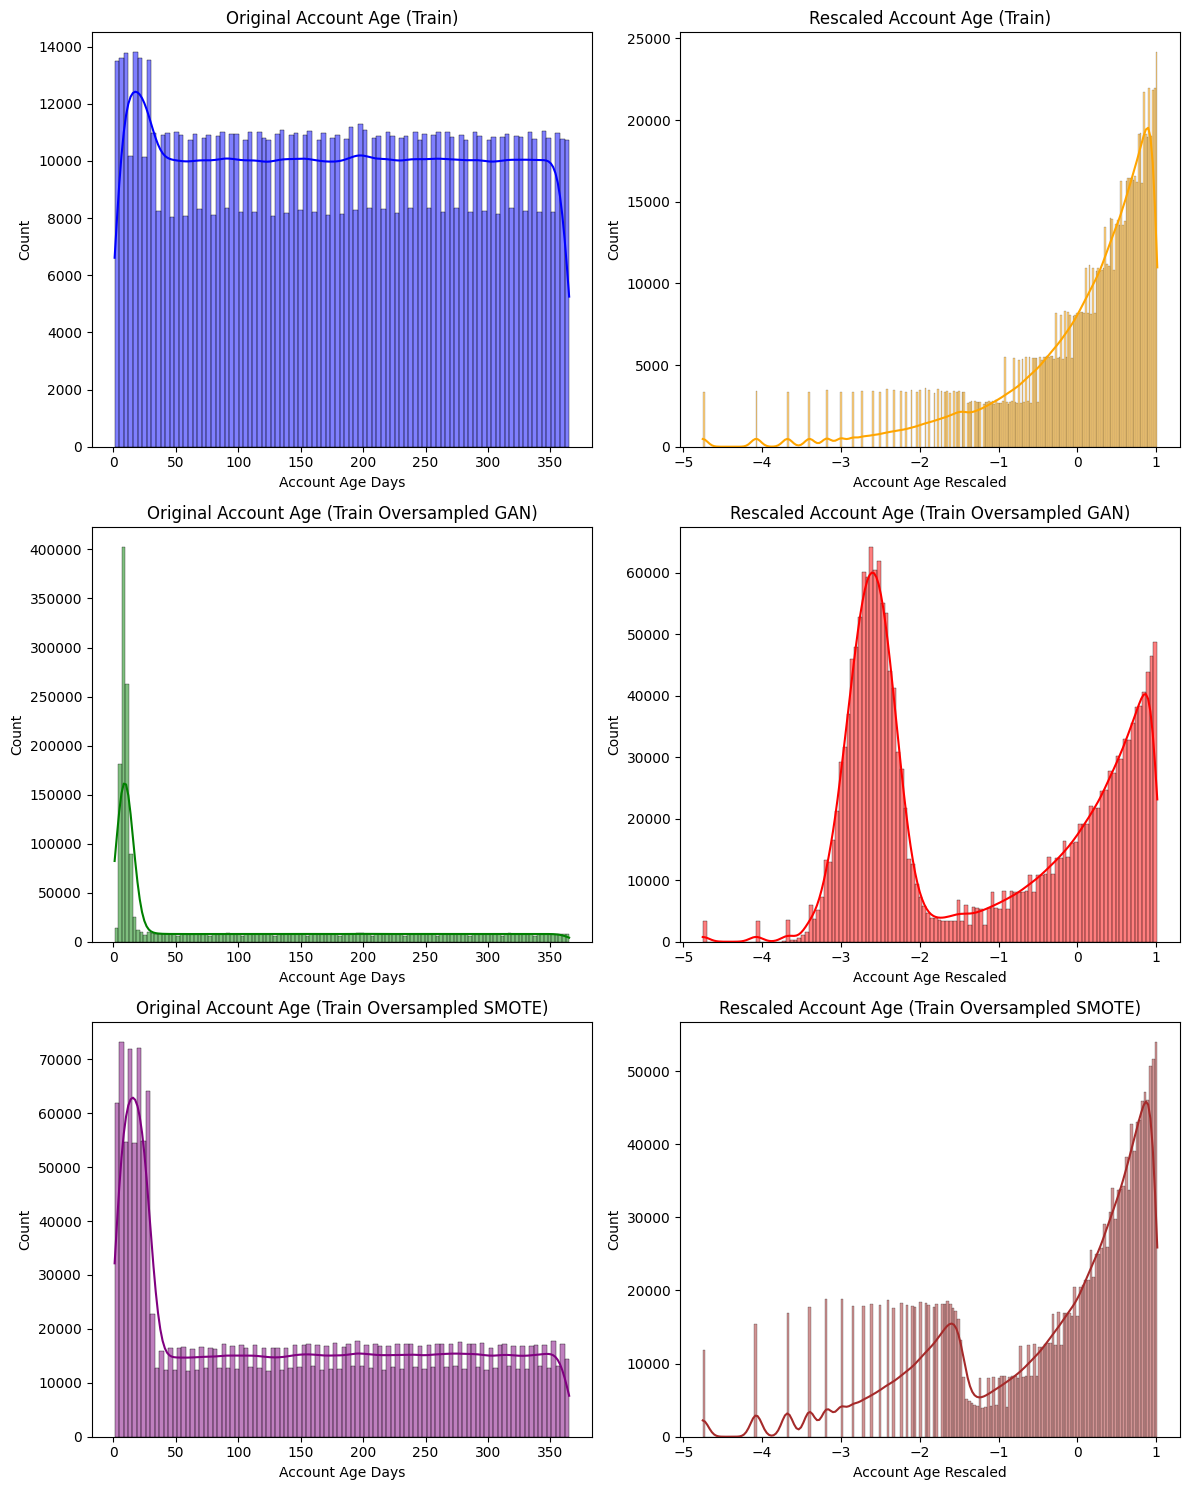

In [29]:
# same plot comparison for account age
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

sns.histplot(train['Account Age Days'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Original Account Age (Train)')
axes[0, 0].set_xlabel('Account Age Days')
axes[0, 0].set_ylabel('Count')

sns.histplot(train['Account Age Rescaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Rescaled Account Age (Train)')
axes[0, 1].set_xlabel('Account Age Rescaled')
axes[0, 1].set_ylabel('Count')

sns.histplot(train_oversampled_GAN['Account Age Days'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Original Account Age (Train Oversampled GAN)')
axes[1, 0].set_xlabel('Account Age Days')
axes[1, 0].set_ylabel('Count')

sns.histplot(train_oversampled_GAN['Account Age Rescaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_title('Rescaled Account Age (Train Oversampled GAN)')
axes[1, 1].set_xlabel('Account Age Rescaled')
axes[1, 1].set_ylabel('Count')

sns.histplot(train_oversampled_SMOTE['Account Age Days'], kde=True, color='purple', ax=axes[2, 0])
axes[2, 0].set_title('Original Account Age (Train Oversampled SMOTE)')
axes[2, 0].set_xlabel('Account Age Days')
axes[2, 0].set_ylabel('Count')

sns.histplot(train_oversampled_SMOTE['Account Age Rescaled'], kde=True, color='brown', ax=axes[2, 1])
axes[2, 1].set_title('Rescaled Account Age (Train Oversampled SMOTE)')
axes[2, 1].set_xlabel('Account Age Rescaled')
axes[2, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


#### Scaling Price per product

In [30]:
# same scaling for product price
scaler = StandardScaler()

train['Product Price Rescaled'] = train['Price per product'].apply(lambda x: np.log10(x))
train['Product Price Rescaled'] = scaler.fit_transform(train[['Product Price Rescaled']])

train_oversampled_GAN['Product Price Rescaled'] = train_oversampled_GAN['Price per product'].apply(lambda x: np.log10(x))
train_oversampled_GAN['Product Price Rescaled'] = scaler.transform(train_oversampled_GAN[['Product Price Rescaled']])

val['Product Price Rescaled'] = val['Price per product'].apply(lambda x: np.log10(x))
val['Product Price Rescaled'] = scaler.transform(val[['Product Price Rescaled']])

test['Product Price Rescaled'] = test['Price per product'].apply(lambda x: np.log10(x))
test['Product Price Rescaled'] = scaler.transform(test[['Product Price Rescaled']])

train_oversampled_SMOTE['Product Price Rescaled'] = train_oversampled_SMOTE['Price per product'].apply(lambda x: np.log10(x))
train_oversampled_SMOTE['Product Price Rescaled'] = scaler.transform(train_oversampled_SMOTE[['Product Price Rescaled']])

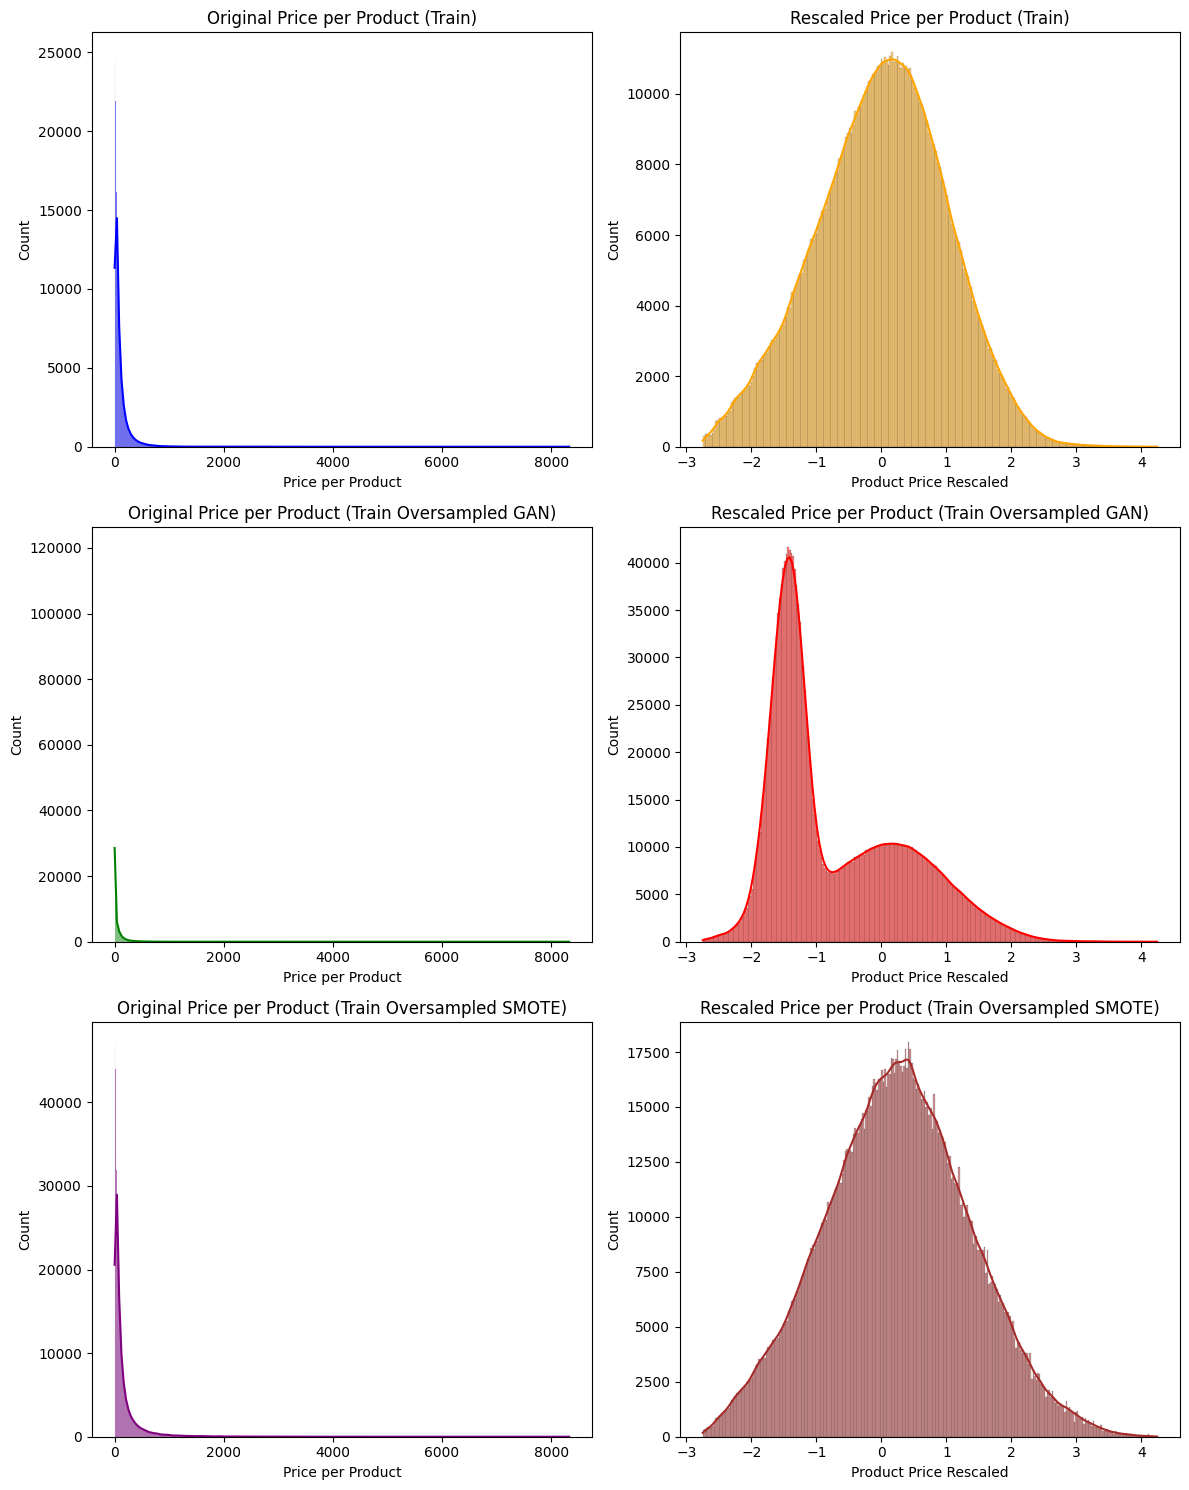

In [31]:
# same plot comparison for product price
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

sns.histplot(train['Price per product'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Price per Product')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Original Price per Product (Train)')

sns.histplot(train['Product Price Rescaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Product Price Rescaled')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Rescaled Price per Product (Train)')

sns.histplot(train_oversampled_GAN['Price per product'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Price per Product')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Original Price per Product (Train Oversampled GAN)')

sns.histplot(train_oversampled_GAN['Product Price Rescaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Product Price Rescaled')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Rescaled Price per Product (Train Oversampled GAN)')

sns.histplot(train_oversampled_SMOTE['Price per product'], kde=True, color='purple', ax=axes[2, 0])
axes[2, 0].set_xlabel('Price per Product')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_title('Original Price per Product (Train Oversampled SMOTE)')

sns.histplot(train_oversampled_SMOTE['Product Price Rescaled'], kde=True, color='brown', ax=axes[2, 1])
axes[2, 1].set_xlabel('Product Price Rescaled')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Rescaled Price per Product (Train Oversampled SMOTE)')

plt.tight_layout()
plt.show()

#### Scaling Quantity

In [28]:
# init min max scaler
min_max_scaler = MinMaxScaler()

# apply scaler to the train set
train['Quantity_Scaled'] = min_max_scaler.fit_transform(train[['Quantity']])

# apply fitted scaler to val, test, gan train, smote train sets
val['Quantity_Scaled'] = min_max_scaler.transform(val[['Quantity']])
test['Quantity_Scaled'] = min_max_scaler.transform(test[['Quantity']])
train_oversampled_GAN['Quantity_Scaled'] = min_max_scaler.transform(train_oversampled_GAN[['Quantity']])
train_oversampled_SMOTE['Quantity_Scaled'] = min_max_scaler.transform(train_oversampled_SMOTE[['Quantity']])

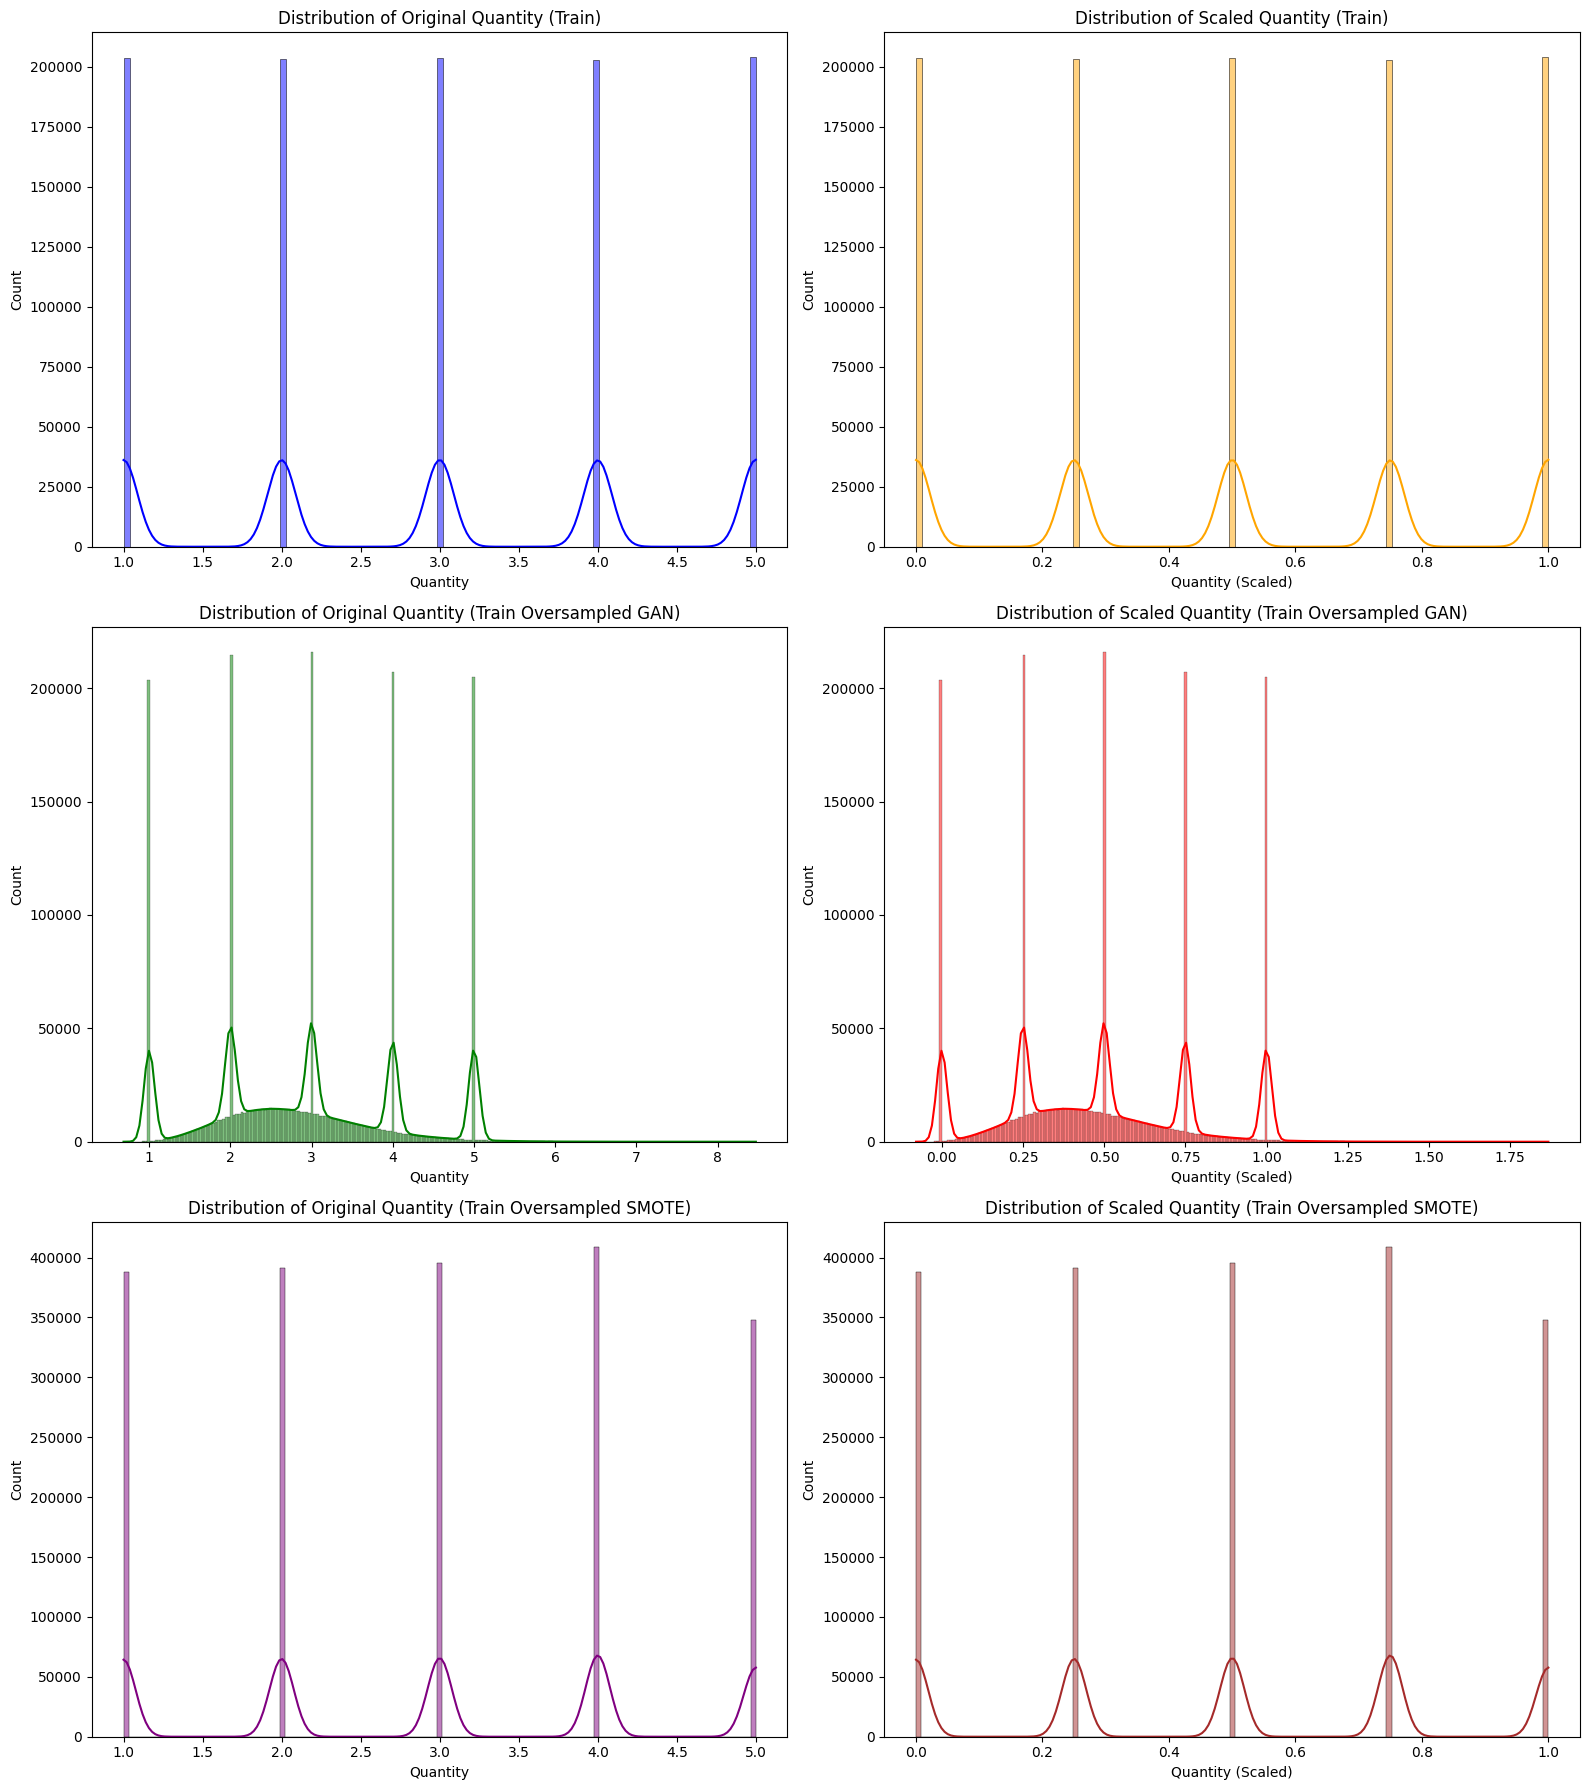

In [33]:
# plot comparison of original vs scaled quantity for train sets
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

sns.histplot(train['Quantity'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Original Quantity (Train)')

sns.histplot(train['Quantity_Scaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Quantity (Scaled)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Scaled Quantity (Train)')

sns.histplot(train_oversampled_GAN['Quantity'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Quantity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Original Quantity (Train Oversampled GAN)')

sns.histplot(train_oversampled_GAN['Quantity_Scaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Quantity (Scaled)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Scaled Quantity (Train Oversampled GAN)')

sns.histplot(train_oversampled_SMOTE['Quantity'], kde=True, color='purple', ax=axes[2, 0])
axes[2, 0].set_xlabel('Quantity')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_title('Distribution of Original Quantity (Train Oversampled SMOTE)')

sns.histplot(train_oversampled_SMOTE['Quantity_Scaled'], kde=True, color='brown', ax=axes[2, 1])
axes[2, 1].set_xlabel('Quantity (Scaled)')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Distribution of Scaled Quantity (Train Oversampled SMOTE)')

plt.tight_layout()
plt.show()

#### Scaling Customer Age

In [34]:
# same standard scale for customer age
standard_scaler = StandardScaler()

train['Customer Age_Scaled'] = standard_scaler.fit_transform(train[['Customer Age']])

val['Customer Age_Scaled'] = standard_scaler.transform(val[['Customer Age']])
test['Customer Age_Scaled'] = standard_scaler.transform(test[['Customer Age']])
train_oversampled_GAN['Customer Age_Scaled'] = standard_scaler.transform(train_oversampled_GAN[['Customer Age']])
train_oversampled_SMOTE['Customer Age_Scaled'] = standard_scaler.transform(train_oversampled_SMOTE[['Customer Age']])

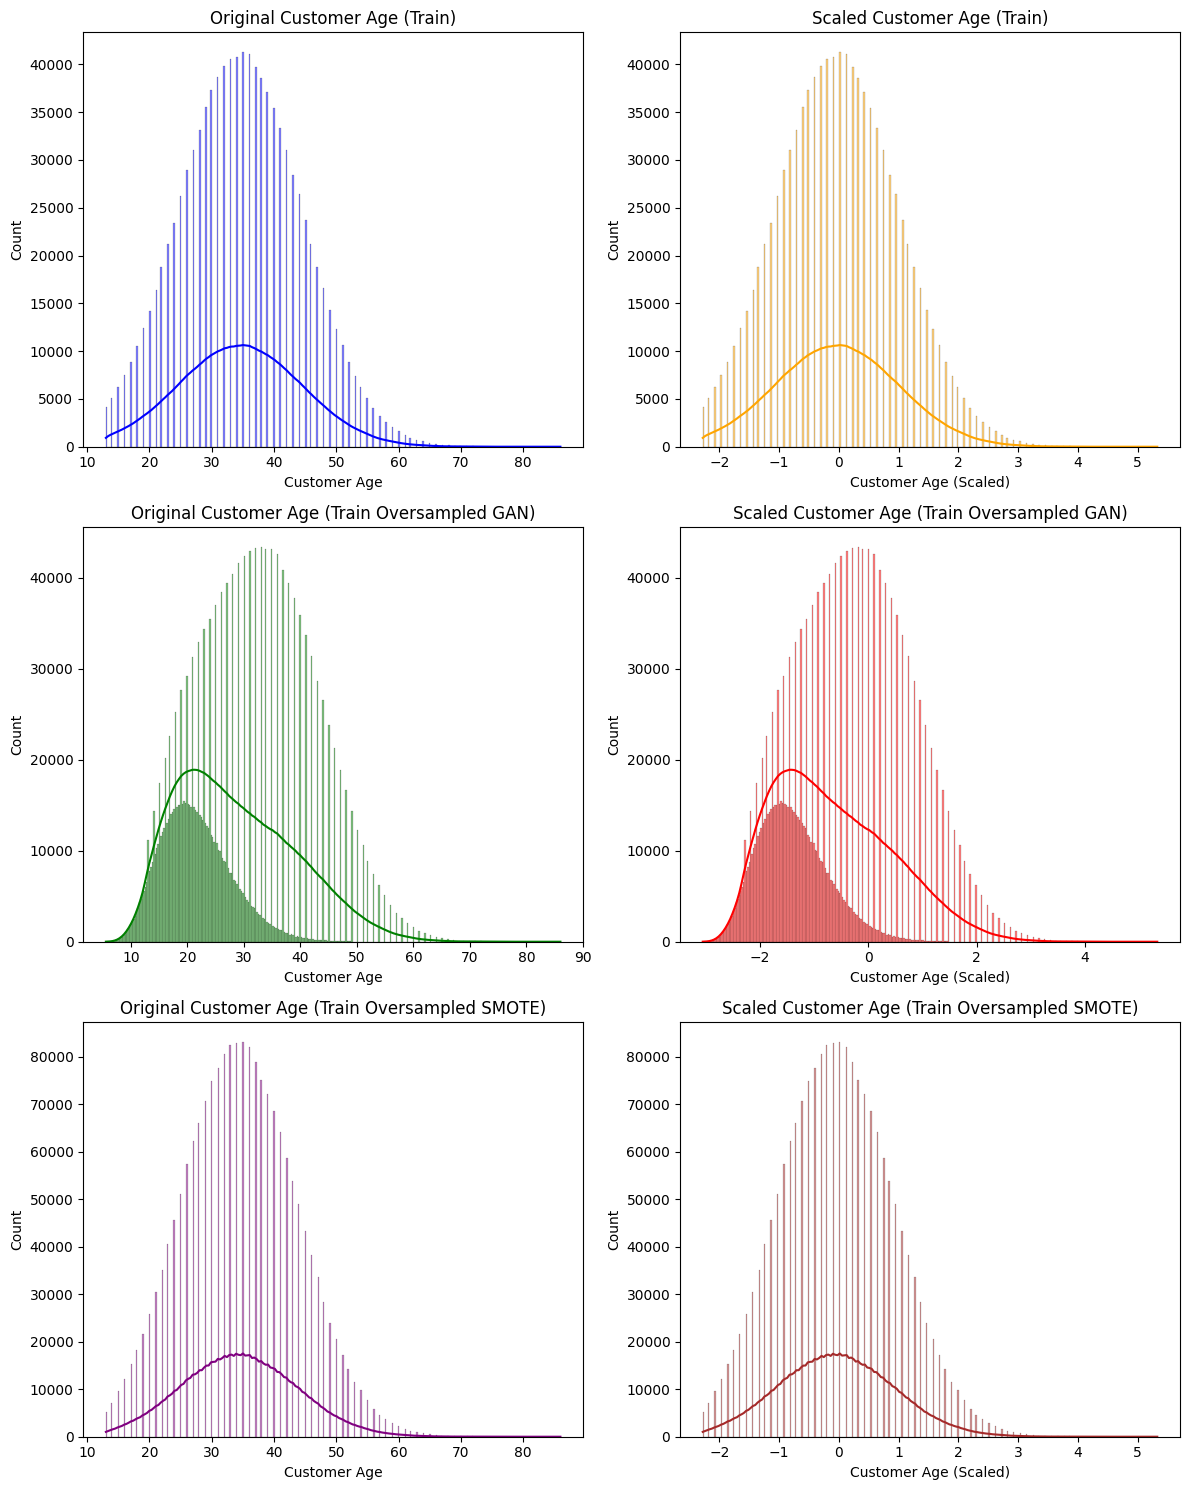

In [35]:
# same plot comparison for customer age
fig, axes = plt.subplots(3, 2, figsize=(12, 15))


sns.histplot(train['Customer Age'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Customer Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Original Customer Age (Train)')

sns.histplot(train['Customer Age_Scaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Customer Age (Scaled)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Scaled Customer Age (Train)')

sns.histplot(train_oversampled_GAN['Customer Age'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Customer Age')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Original Customer Age (Train Oversampled GAN)')

sns.histplot(train_oversampled_GAN['Customer Age_Scaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Customer Age (Scaled)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Scaled Customer Age (Train Oversampled GAN)')

sns.histplot(train_oversampled_SMOTE['Customer Age'], kde=True, color='purple', ax=axes[2, 0])
axes[2, 0].set_xlabel('Customer Age')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_title('Original Customer Age (Train Oversampled SMOTE)')

sns.histplot(train_oversampled_SMOTE['Customer Age_Scaled'], kde=True, color='brown', ax=axes[2, 1])
axes[2, 1].set_xlabel('Customer Age (Scaled)')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Scaled Customer Age (Train Oversampled SMOTE)')

plt.tight_layout()
plt.show()


### After all cleaning is done

In [36]:
display(train.head())
print(train.shape)

Transaction Amount  Quantity  Customer Age  Account Age Days  \
904466              108.85         4            41               342   
394104               24.90         5            24               155   
503616               18.20         4            22               237   
304747              366.46         1            29                85   
131498               25.79         2            27               133   

        Transaction Hour  Parent_Assisted_Purchase  Age Group  \
904466                23                         0          3   
394104                15                         0          1   
503616                16                         0          1   
304747                12                         0          1   
131498                 5                         0          1   

        Transaction Day  Transaction Day of Week  Transaction Month  \
904466               15                        3                  2   
394104               21                        3                  3   
503616               28                        6                  1   
304747               13                        5                  1   
131498               18                        6                  2   

        Time of Day  isAddressMatched  Price per product  Time of Day_0  \
904466            3                 1            27.2125            0.0   
394104            2                 1             4.9800            0.0   
503616            2                 1             4.5500            0.0   
304747            2                 1           366.4600            0.0   
131498            0                 0            12.8950            1.0   

        Time of Day_1  Time of Day_2  Time of Day_3  Age Group_0  Age Group_1  \
904466            0.0            0.0            1.0          0.0          0.0   
394104            0.0            1.0            0.0          0.0          1.0   
503616            0.0            1.0            0.0          0.0          1.0   
304747            0.0            1.0            0.0          0.0          1.0   
131498            0.0            0.0            0.0          0.0          1.0   

        Age Group_2  Age Group_3  Age Group_4  Age Group_5  \
904466          0.0          1.0          0.0          0.0   
394104          0.0          0.0          0.0          0.0   
503616          0.0          0.0          0.0          0.0   
304747          0.0          0.0          0.0          0.0   
131498          0.0          0.0          0.0          0.0   

        Payment Method_PayPal  Payment Method_bank transfer  \
904466                    1.0                           0.0   
394104                    0.0                           1.0   
503616                    1.0                           0.0   
304747                    0.0                           0.0   
131498                    0.0                           1.0   

        Payment Method_credit card  Payment Method_debit card  \
904466                         0.0                        0.0   
394104                         0.0                        0.0   
503616                         0.0                        0.0   
304747                         0.0                        1.0   
131498                         0.0                        0.0   

        Product Category_clothing  Product Category_electronics  \
904466                        0.0                           0.0   
394104                        0.0                           0.0   
503616                        0.0                           1.0   
304747                        0.0                           0.0   
131498                        1.0                           0.0   

        Product Category_health & beauty  Product Category_home & garden  \
904466                               0.0                             1.0   
394104                               0.0                             1.0   
503616                               0.0     

(1016784, 53)


In [37]:
display(train_oversampled_GAN.head())
print(train_oversampled_GAN.shape)

Transaction Amount  Quantity  Customer Age  Account Age Days  \
0              108.85       4.0          41.0             342.0   
1               24.90       5.0          24.0             155.0   
2               18.20       4.0          22.0             237.0   
3              366.46       1.0          29.0              85.0   
4               25.79       2.0          27.0             133.0   

   Transaction Hour  Parent_Assisted_Purchase  Age Group  Transaction Day  \
0              23.0                       0.0        3.0             15.0   
1              15.0                       0.0        1.0             21.0   
2              16.0                       0.0        1.0             28.0   
3              12.0                       0.0        1.0             13.0   
4               5.0                       0.0        1.0             18.0   

   Transaction Day of Week  Transaction Month  Time of Day  isAddressMatched  \
0                      3.0                2.0          3.0               1.0   
1                      3.0                3.0          2.0               1.0   
2                      6.0                1.0          2.0               1.0   
3                      5.0                1.0          2.0               1.0   
4                      6.0                2.0          0.0               0.0   

   Price per product  Time of Day_0  Time of Day_1  Time of Day_2  \
0            27.2125            0.0            0.0            0.0   
1             4.9800            0.0            0.0            1.0   
2             4.5500            0.0            0.0            1.0   
3           366.4600            0.0            0.0            1.0   
4            12.8950            1.0            0.0            0.0   

   Time of Day_3  Age Group_0  Age Group_1  Age Group_2  Age Group_3  \
0            1.0          0.0          0.0          0.0          1.0   
1            0.0          0.0          1.0          0.0          0.0   
2            0.0          0.0          1.0          0.0          0.0   
3            0.0          0.0          1.0          0.0          0.0   
4            0.0          0.0          1.0          0.0          0.0   

   Age Group_4  Age Group_5  Payment Method_PayPal  \
0          0.0          0.0                    1.0   
1          0.0          0.0                    0.0   
2          0.0          0.0                    1.0   
3          0.0          0.0                    0.0   
4          0.0          0.0                    0.0   

   Payment Method_bank transfer  Payment Method_credit card  \
0                           0.0                         0.0   
1                           1.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           1.0                         0.0   

   Payment Method_debit card  Product Category_clothing  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        1.0                        0.0   
4                        0.0                        1.0   

   Product Category_electronics  Product Category_health & beauty  \
0                           0.0                               0.0   
1                           0.0                               0.0   
2                           1.0                               0.0   
3                           0.0                               1.0   
4                           0.0                               0.0   

   Product Category_home & garden  Product Category_toys & games  \
0                             1.0                            0.0   
1                             1.0                            0.0   
2                             0.0                            0.0   
3                             0.0                            0

(1931634, 53)


In [34]:
display(train_oversampled_SMOTE.head())
print(train_oversampled_SMOTE.shape)

Transaction Amount  Quantity  Customer Age  Account Age Days  \
0              108.85         4            41               342   
1               24.90         5            24               155   
2               18.20         4            22               237   
3              366.46         1            29                85   
4               25.79         2            27               133   

   Transaction Hour  Parent_Assisted_Purchase  Age Group  Transaction Day  \
0                23                         0          3               15   
1                15                         0          1               21   
2                16                         0          1               28   
3                12                         0          1               13   
4                 5                         0          1               18   

   Transaction Day of Week  Transaction Month  Time of Day  isAddressMatched  \
0                        3                  2            3                 1   
1                        3                  3            2                 1   
2                        6                  1            2                 1   
3                        5                  1            2                 1   
4                        6                  2            0                 0   

   Price per product  Time of Day_0  Time of Day_1  Time of Day_2  \
0            27.2125            0.0            0.0            0.0   
1             4.9800            0.0            0.0            1.0   
2             4.5500            0.0            0.0            1.0   
3           366.4600            0.0            0.0            1.0   
4            12.8950            1.0            0.0            0.0   

   Time of Day_3  Age Group_0  Age Group_1  Age Group_2  Age Group_3  \
0            1.0          0.0          0.0          0.0          1.0   
1            0.0          0.0          1.0          0.0          0.0   
2            0.0          0.0          1.0          0.0          0.0   
3            0.0          0.0          1.0          0.0          0.0   
4            0.0          0.0          1.0          0.0          0.0   

   Age Group_4  Age Group_5  Payment Method_PayPal  \
0          0.0          0.0                    1.0   
1          0.0          0.0                    0.0   
2          0.0          0.0                    1.0   
3          0.0          0.0                    0.0   
4          0.0          0.0                    0.0   

   Payment Method_bank transfer  Payment Method_credit card  \
0                           0.0                         0.0   
1                           1.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           1.0                         0.0   

   Payment Method_debit card  Product Category_clothing  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        1.0                        0.0   
4                        0.0                        1.0   

   Product Category_electronics  Product Category_health & beauty  \
0                           0.0                               0.0   
1                           0.0                               0.0   
2                           1.0                               0.0   
3                           0.0                               1.0   
4                           0.0                               0.0   

   Product Category_home & garden  Product Category_toys & games  \
0                             1.0                            0.0   
1                             1.0                            0.0   
2                             0.0                            0.0   
3                             0.0                            0

(1931634, 53)


# Features for Logistic Regression, XGBoost and RandomForest

In [65]:
X_train_oversampled = train_oversampled_SMOTE.drop(columns=[
                                            'Is Fraudulent',
                                            'Transaction Amount',
                                            'Price per product',
                                            'Quantity_Scaled',
                                            'Customer Age_Scaled',
                                            'Customer Age',
                                            'Transaction Hour',
                                            'Age Group',
                                           'Time of Day',
                                           'Account Age Days',
                                           'Transaction Month',
                                           'Transaction Day of Week'
                                           ])
y_train_oversampled = train_oversampled_SMOTE['Is Fraudulent']
X_val = val[X_train_oversampled.columns]
y_val = val['Is Fraudulent']
X_test = test[X_train_oversampled.columns]
y_test = test['Is Fraudulent']  
print(X_train_oversampled.columns)

Index(['Quantity', 'Parent_Assisted_Purchase', 'Transaction Day',
       'isAddressMatched', 'Time of Day_0', 'Time of Day_1', 'Time of Day_2',
       'Time of Day_3', 'Age Group_0', 'Age Group_1', 'Age Group_2',
       'Age Group_3', 'Age Group_4', 'Age Group_5', 'Payment Method_PayPal',
       'Payment Method_bank transfer', 'Payment Method_credit card',
       'Payment Method_debit card', 'Product Category_clothing',
       'Product Category_electronics', 'Product Category_health & beauty',
       'Product Category_home & garden', 'Product Category_toys & games',
       'Device Used_desktop', 'Device Used_mobile', 'Device Used_tablet',
       'Transaction Month_1', 'Transaction Month_2', 'Transaction Month_3',
       'Transaction Month_4', 'Transaction Day of Week_0',
       'Transaction Day of Week_1', 'Transaction Day of Week_2',
       'Transaction Day of Week_3', 'Transaction Day of Week_4',
       'Transaction Day of Week_5', 'Transaction Day of Week_6',
       'custLocEncoded'

## **Logistic Regression**

In [41]:
# define the logistic regression model
logit = LogisticRegression(random_state=42, max_iter=10000, C=10)
logit.fit(X_train_oversampled, y_train_oversampled)

logit_pred = logit.predict(X_val)
logit_proba = logit.predict_proba(X_val)[:, 1]

# accuracy of model
logit_accuracy = accuracy_score(y_val, logit_pred)

# roc auc of model
logit_roc_auc = roc_auc_score(y_val, logit_proba)

print("Classification Report:\n", classification_report(y_val, logit_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, logit_pred))
print(f"Logistic Regression Accuracy: {logit_accuracy}")
print(f"Logistic Regression ROC-AUC: {logit_roc_auc}")

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.87    206961
           1       0.12      0.52      0.19     10921

    accuracy                           0.78    217882
   macro avg       0.54      0.66      0.53    217882
weighted avg       0.93      0.78      0.84    217882

Confusion Matrix:
 [[165012  41949]
 [  5249   5672]]
Logistic Regression Accuracy: 0.7833781588199117
Logistic Regression ROC-AUC: 0.7224698870065978


In [43]:
param_grid = {
    'C': [0.1, 1, 10],           
    'penalty': ['l1', 'l2'],      
    'solver': ['liblinear', 'saga']  
}
# init logistic regression model
lr_model = LogisticRegression(max_iter=10000, random_state=42)

# init grid search
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    cv=3,             
    scoring='roc_auc', 
    n_jobs=-1,         
    verbose=2          
)

grid_search.fit(X_train_oversampled, y_train_oversampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC Score: {grid_search.best_score_}")

best_lr_model = grid_search.best_estimator_
y_pred_proba_val = best_lr_model.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print(f"Validation ROC AUC Score: {roc_auc_val}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  50.8s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  54.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  30.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time= 4.4min
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time= 3.6min
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time= 4.7min
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time= 3.4min
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time= 4.8min
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time= 4.9min
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time= 5.1min
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time= 5.1min
[CV] END ..................C=1, penalty=l2, solv

In [44]:
# tuned lr model's prediction on validation set
best_params = grid_search.best_params_

best_lr_model = LogisticRegression(
    max_iter=10000,
    random_state=42,
    **best_params  
)

best_lr_model.fit(X_train_oversampled, y_train_oversampled)


y_pred_test = best_lr_model.predict(X_val)
y_pred_proba_test = best_lr_model.predict_proba(X_val)[:, 1]

print("Test Classification Report:")
print(classification_report(y_val, y_pred_test))

print("Test Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_test))

logit_accuracy = accuracy_score(y_val, y_pred_test)

print(f"Logistic Regression Accuracy: {logit_accuracy}")

roc_auc_test = roc_auc_score(y_val, y_pred_proba_test)
print(f"Test ROC-AUC Score: {roc_auc_test}")

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.87    206961
           1       0.12      0.52      0.19     10921

    accuracy                           0.78    217882
   macro avg       0.54      0.66      0.53    217882
weighted avg       0.93      0.78      0.84    217882

Test Confusion Matrix:
[[165008  41953]
 [  5247   5674]]
Logistic Regression Accuracy: 0.7833689795393837
Test ROC-AUC Score: 0.7226157705233791


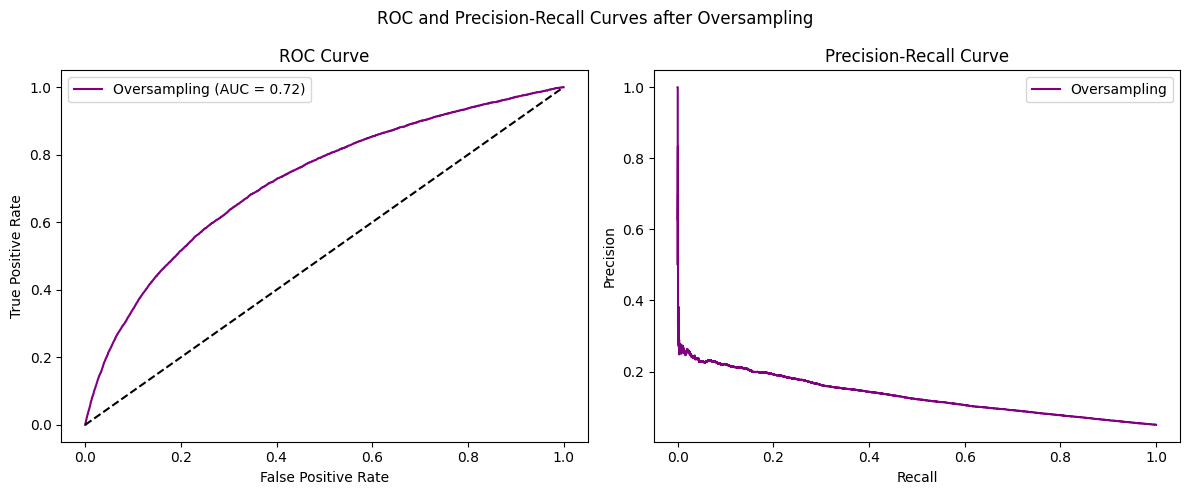

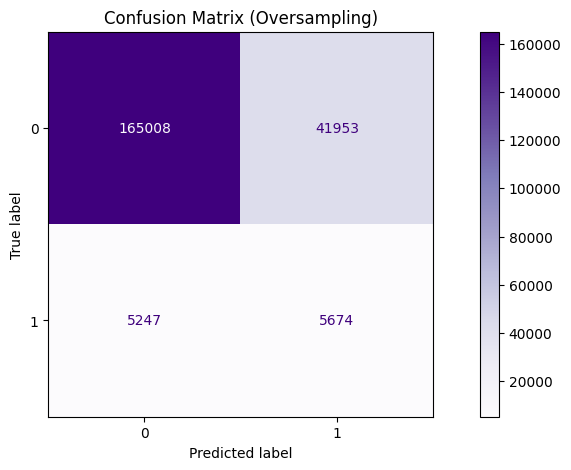

In [46]:
# def function to plot roc
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, color='purple', label=f"{label} (AUC = {auc_score:.2f})")  
    ax.plot([0, 1], [0, 1], 'k--')  
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend()  

# def function to plot precision recall curve
def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, color='purple', label=label)  
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend()  

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# roc curve
plot_roc_curve(axes[0], y_val, y_pred_proba_test, "Oversampling")

# precision recall curve
plot_precision_recall_curve(axes[1], y_val, y_pred_proba_test, "Oversampling")

plt.suptitle("ROC and Precision-Recall Curves after Oversampling")
plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
fig, ax = plt.subplots(figsize=(12, 5))  
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_test, ax=ax, cmap="Purples")
ax.set_title("Confusion Matrix (Oversampling)")

plt.show()


In [47]:
# tuned lr model's prediction on test set
y_pred_test = best_lr_model.predict(X_test)
y_pred_proba_test = best_lr_model.predict_proba(X_test)[:, 1]

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

logit_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Logistic Regression Accuracy: {logit_accuracy}")

roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
print(f"Test ROC-AUC Score: {roc_auc_test}")

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.87    206961
           1       0.12      0.53      0.20     10922

    accuracy                           0.78    217883
   macro avg       0.55      0.66      0.54    217883
weighted avg       0.93      0.78      0.84    217883

Test Confusion Matrix:
[[164775  42186]
 [  5139   5783]]
Logistic Regression Accuracy: 0.7827962713933625
Test ROC-AUC Score: 0.7241312736289263


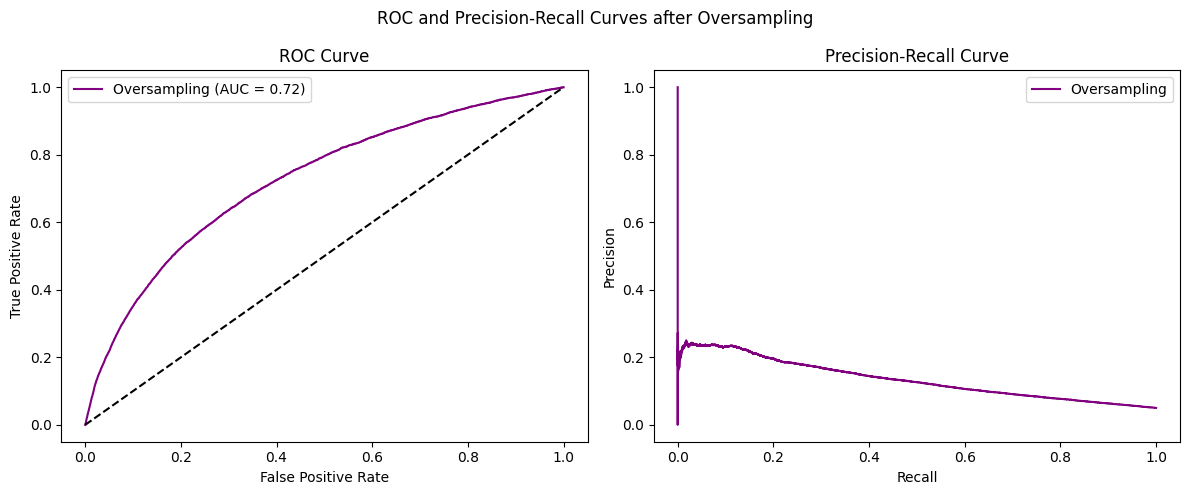

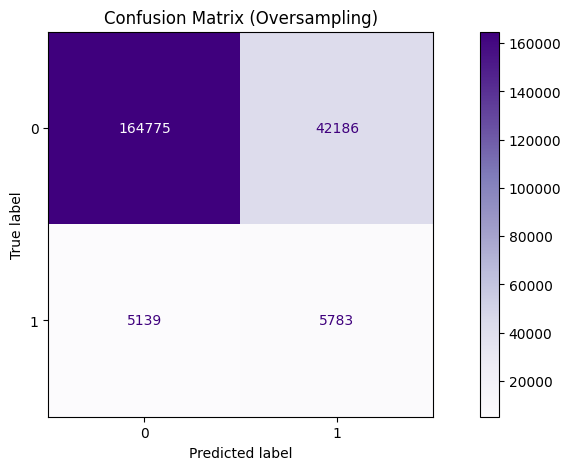

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# roc curve
plot_roc_curve(axes[0], y_test, y_pred_proba_test, "Oversampling")

# precision recall curve
plot_precision_recall_curve(axes[1], y_test, y_pred_proba_test, "Oversampling")

plt.suptitle("ROC and Precision-Recall Curves after Oversampling")
plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
fig, ax = plt.subplots(figsize=(12, 5))  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax, cmap="Purples")
ax.set_title("Confusion Matrix (Oversampling)")

plt.show()

## **Gradient Boosting**

In [53]:
# define the XGBoost model
model_oversampled = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)

model_oversampled.fit(
    X_train_oversampled,
    y_train_oversampled,
)

# predict the labels
y_pred_oversampled = model_oversampled.predict(X_val)

y_pred_proba_oversampled = model_oversampled.predict_proba(X_val)[:, 1]

print("Classification Report:\n", classification_report(y_val, y_pred_oversampled))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_oversampled))
print("Accuracy Score:", accuracy_score(y_val, y_pred_oversampled))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba_oversampled))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97    206961
           1       0.54      0.17      0.26     10921

    accuracy                           0.95    217882
   macro avg       0.75      0.58      0.62    217882
weighted avg       0.94      0.95      0.94    217882

Confusion Matrix:
 [[205385   1576]
 [  9092   1829]]
Accuracy Score: 0.9510377176636895
ROC AUC Score: 0.7403983714547082


In [ ]:
# hyperparameter tuning for xgb

param_dist = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  
    scoring='roc_auc',
    cv=5,  
    n_jobs=-1, 
    verbose=2
)

random_search.fit(X_train_oversampled, y_train_oversampled)

best_params = random_search.best_params_

print("Best Parameters:\n", best_params)

# Fitting 5 folds for each of 20 candidates, totalling 100 fits
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  33.5s
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  35.2s
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  35.5s
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  40.0s
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  41.4s
# [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=  59.8s
# [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time= 1.0min
# [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time= 1.0min
# [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  34.5s
# [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  35.3s
# [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  36.0s
# [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=  57.9s
# [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time= 1.0min
# [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  37.7s
# [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  38.9s
# [CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  24.6s
# [CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  24.8s
# [CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  23.7s
# [CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time= 1.1min
# [CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time= 1.1min
# [CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time= 1.1min
# [CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time= 1.0min
# [CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  25.3s
# [CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time= 1.1min
# ...
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=200, subsample=1.0; total time=  54.6s
# [CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=200, subsample=1.0; total time=  49.5s
# Best Parameters:
#  {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

In [54]:
# tuned xgb model's prediction on validation set

# hard code best params so as to avoid waiting for random search to run
# best_params = {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
best_params = random_search.best_params_

model_oversampled_tuned = xgb.XGBClassifier(
    random_state=42,               
    **best_params
)

model_oversampled_tuned.fit(
    X_train_oversampled,
    y_train_oversampled,
)

# predict the labels
y_pred_oversampled_tuned = model_oversampled_tuned.predict(X_val)

y_pred_proba_oversampled_tuned = model_oversampled_tuned.predict_proba(X_val)[:, 1]

print("Classification Report:\n", classification_report(y_val, y_pred_oversampled_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_oversampled_tuned))
print("Accuracy Score:", accuracy_score(y_val, y_pred_oversampled_tuned))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba_oversampled_tuned))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97    206961
           1       0.54      0.18      0.27     10921

    accuracy                           0.95    217882
   macro avg       0.75      0.59      0.62    217882
weighted avg       0.94      0.95      0.94    217882

Confusion Matrix:
 [[205267   1694]
 [  8942   1979]]
Accuracy Score: 0.9511845861521374
ROC AUC Score: 0.7515393128040646


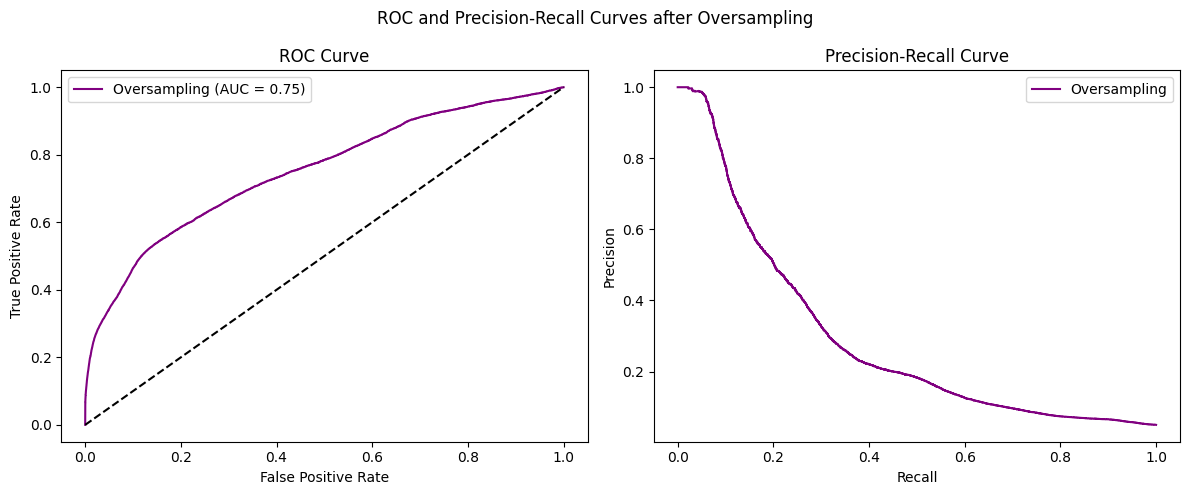

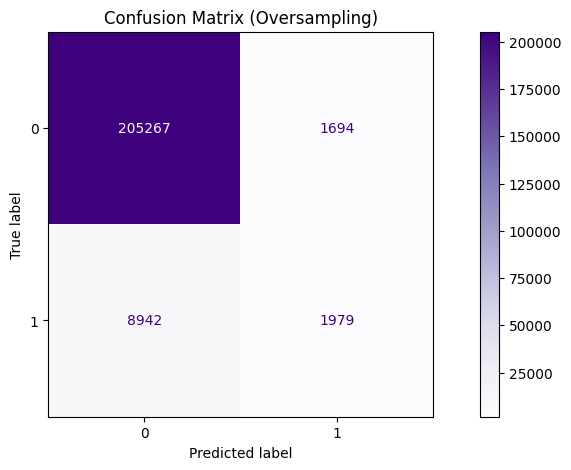

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# roc curve
plot_roc_curve(axes[0], y_val, y_pred_proba_oversampled_tuned, "Oversampling")

# precision recall curve
plot_precision_recall_curve(axes[1], y_val, y_pred_proba_oversampled_tuned, "Oversampling")

plt.suptitle("ROC and Precision-Recall Curves after Oversampling")
plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
fig, ax = plt.subplots(figsize=(12, 5))  
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_oversampled_tuned, ax=ax, cmap="Purples")
ax.set_title("Confusion Matrix (Oversampling)")

plt.show()

In [56]:
# tuned xgb model's prediction on test set
y_pred_oversampled_tuned = model_oversampled_tuned.predict(X_test)

y_pred_proba_oversampled_tuned = model_oversampled_tuned.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_oversampled_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_oversampled_tuned))
print("Accuracy Score:", accuracy_score(y_test, y_pred_oversampled_tuned))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_oversampled_tuned))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97    206961
           1       0.54      0.18      0.27     10922

    accuracy                           0.95    217883
   macro avg       0.75      0.59      0.62    217883
weighted avg       0.94      0.95      0.94    217883

Confusion Matrix:
 [[205257   1704]
 [  8928   1994]]
Accuracy Score: 0.9512031686730952
ROC AUC Score: 0.7536294479839938


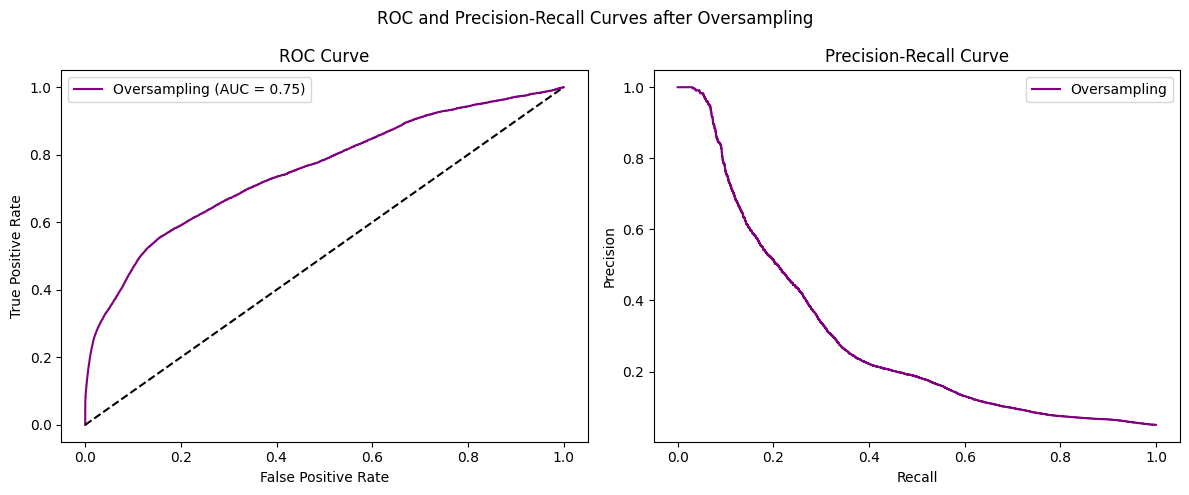

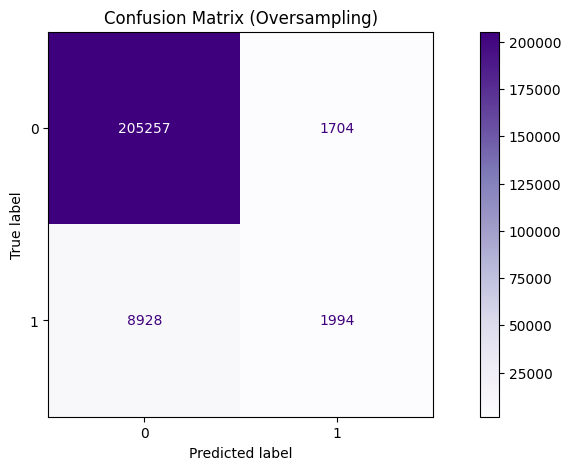

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# roc curve
plot_roc_curve(axes[0], y_test, y_pred_proba_oversampled_tuned, "Oversampling")

# precision recall curve
plot_precision_recall_curve(axes[1], y_test, y_pred_proba_oversampled_tuned, "Oversampling")

plt.suptitle("ROC and Precision-Recall Curves after Oversampling")
plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
fig, ax = plt.subplots(figsize=(12, 5))  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_oversampled_tuned, ax=ax, cmap="Purples")
ax.set_title("Confusion Matrix (Oversampling)")

plt.show()

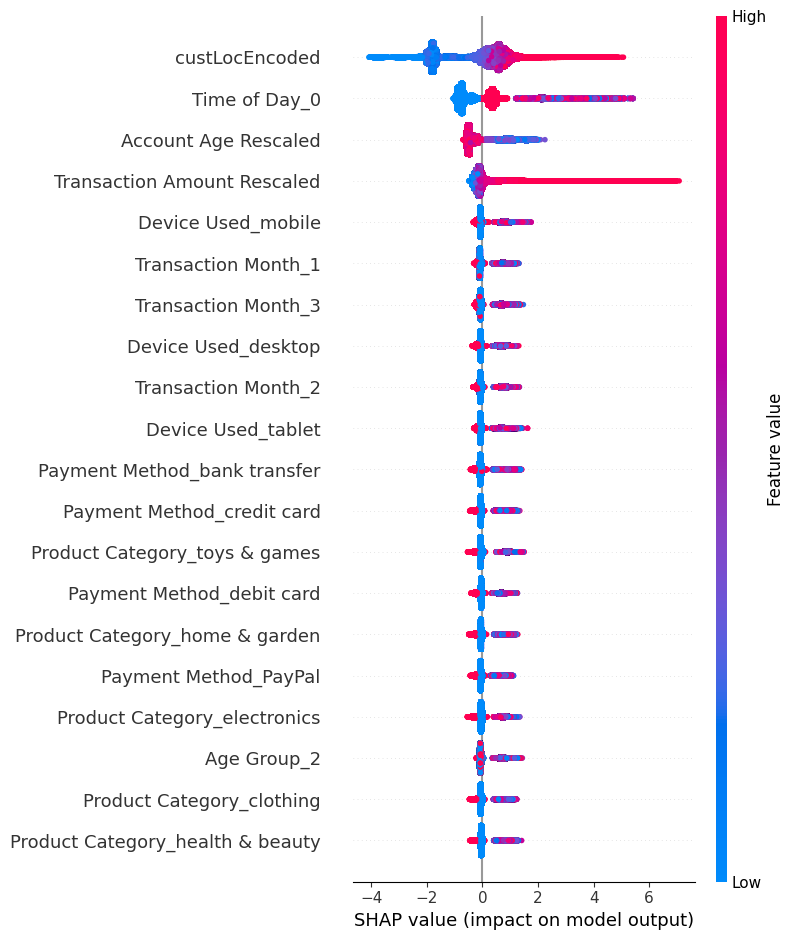

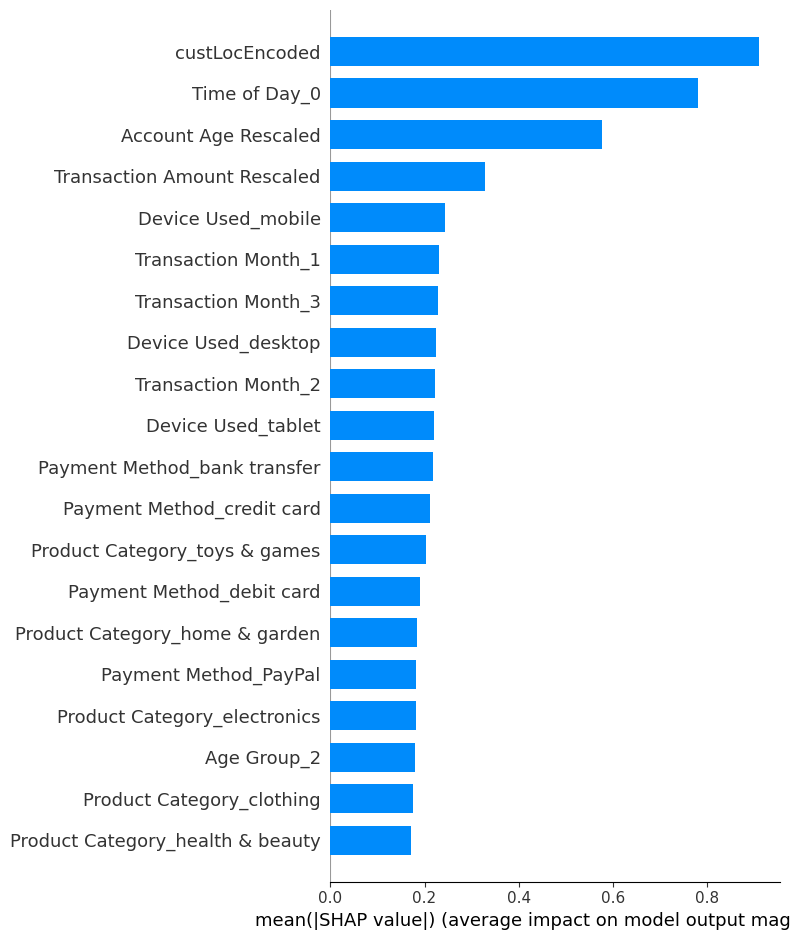

In [69]:
# using shap values to find out feature importance
import shap

explainer = shap.TreeExplainer(model_oversampled_tuned)
shap_values = explainer.shap_values(X_train_oversampled)

shap.summary_plot(shap_values, X_train_oversampled)
shap.summary_plot(shap_values, X_train_oversampled, plot_type="bar")

## **Random Forest**

In [66]:
# def hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 75, 100],  
    'max_depth': [None, 10, 15],    
    'max_features': ['sqrt'],  
    'bootstrap': [True],
    'min_samples_split': [2, 4, 5], 
    'min_samples_leaf': [1, 2, 3],  
}

# init rf model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# init RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  
    cv=3,       
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

print("Starting hyperparameter tuning...")
# random_search.fit(X_train_oversampled, y_train_oversampled)

# get the best model from the search
best_model = random_search.best_estimator_
# print("Best Hyperparameters:", random_search.best_params_)

# best_params = {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

best_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)

best_model.fit(X_train_oversampled, y_train_oversampled)

# predict on validation data
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]  # For AUC score

# Evaluate on validation set
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\nValidation ROC AUC Score:", roc_auc_score(y_val, y_val_proba))

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # For AUC score
print("\nValidation Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nValidation ROC AUC Score:", roc_auc_score(y_test, y_test_proba))

Starting hyperparameter tuning...

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    206961
           1       0.61      0.17      0.26     10921

    accuracy                           0.95    217882
   macro avg       0.78      0.58      0.62    217882
weighted avg       0.94      0.95      0.94    217882


Validation Confusion Matrix:
[[205803   1158]
 [  9113   1808]]

Validation ROC AUC Score: 0.7576067878467858

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    206961
           1       0.61      0.17      0.27     10922

    accuracy                           0.95    217883
   macro avg       0.78      0.58      0.62    217883
weighted avg       0.94      0.95      0.94    217883


Validation Confusion Matrix:
[[205776   1185]
 [  9070   1852]]

Validation ROC AUC Score: 0.7571445059077001


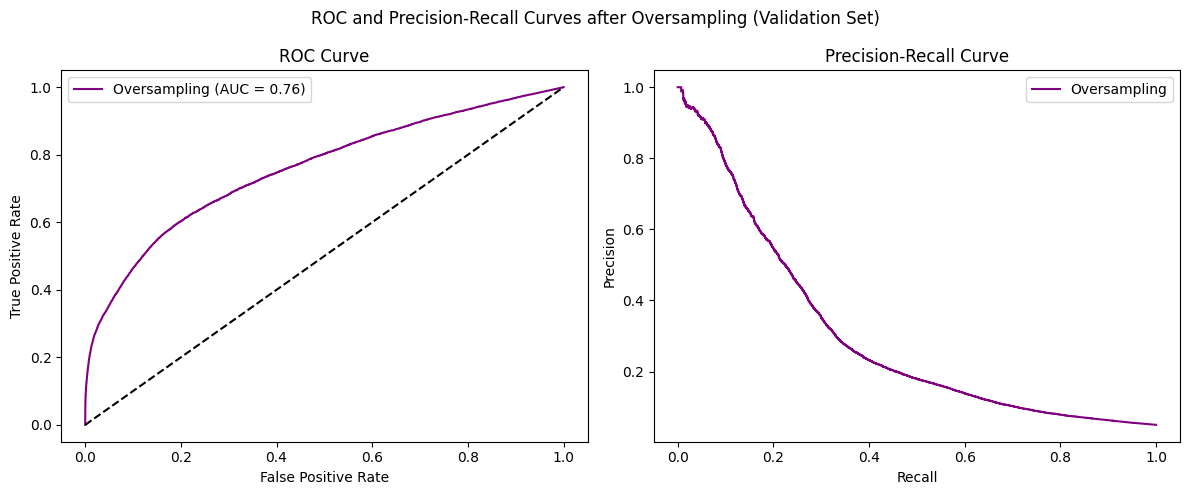

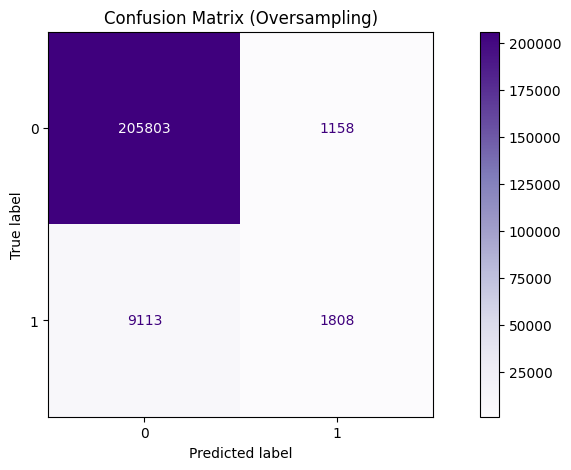

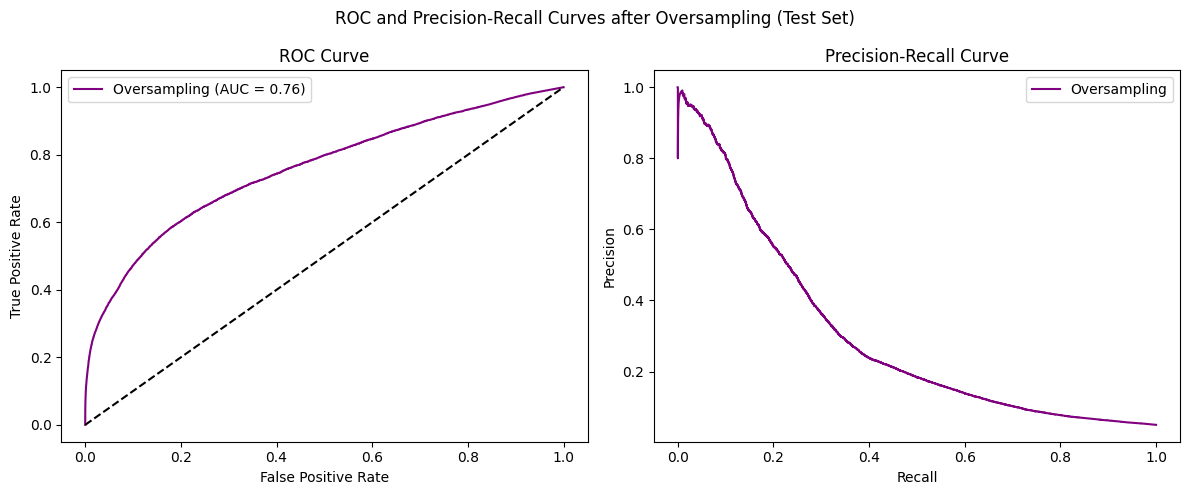

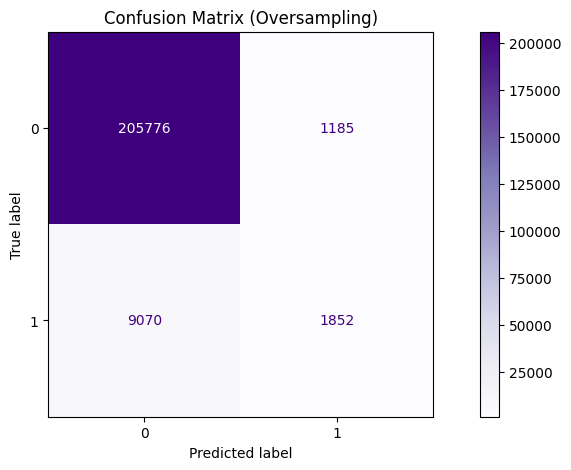

In [68]:
# plot for val predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# roc curve
plot_roc_curve(axes[0], y_val, y_val_proba, "Oversampling")

# precision recall curve
plot_precision_recall_curve(axes[1], y_val, y_val_proba, "Oversampling")

plt.suptitle("ROC and Precision-Recall Curves after Oversampling (Validation Set)")
plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
fig, ax = plt.subplots(figsize=(12, 5))  
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=ax, cmap="Purples")
ax.set_title("Confusion Matrix (Oversampling)")

plt.show()



# plot for test predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# roc curve
plot_roc_curve(axes[0], y_test, y_test_proba, "Oversampling")

# precision recall curve
plot_precision_recall_curve(axes[1], y_test, y_test_proba, "Oversampling")

plt.suptitle("ROC and Precision-Recall Curves after Oversampling (Test Set)")
plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
fig, ax = plt.subplots(figsize=(12, 5))  
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax, cmap="Purples")
ax.set_title("Confusion Matrix (Oversampling)")

plt.show()

# Features chosen for Neural Network

In [62]:
chosen_features = ['Transaction Amount Rescaled', 'Transaction Month_1', 'Transaction Month_2', 'Transaction Month_3', 'Transaction Month_4',
                    'Transaction Day of Week_0', 'Transaction Day of Week_1', 'Transaction Day of Week_2', 'Transaction Day of Week_3', 'Transaction Day of Week_4', 'Transaction Day of Week_5', 'Transaction Day of Week_6',
                    'Payment Method_PayPal', 'Payment Method_bank transfer', 'Payment Method_credit card', 'Payment Method_debit card',
                    'Product Category_clothing', 'Product Category_electronics', 'Product Category_health & beauty', 'Product Category_home & garden', 'Product Category_toys & games',
                    'Quantity_Scaled', 'Product Price Rescaled', 'Customer Age_Scaled', 'Parent_Assisted_Purchase', 'custLocEncoded', 'Device Used_desktop', 'Device Used_mobile', 'Device Used_tablet', 'isAddressMatched', 'Account Age Rescaled', 'Time of Day_0', 'Time of Day_1', 'Time of Day_2', 'Time of Day_3', 'Is Fraudulent']

train_copy = train.copy()
train_oversampled_GAN_copy = train_oversampled_GAN.copy()
val_copy = val.copy()
test_copy = test.copy()
train_oversampled_SMOTE_copy = train_oversampled_SMOTE.copy()

train_cleaned = train_copy[chosen_features]
train_oversampled_GAN_cleaned = train_oversampled_GAN_copy[chosen_features]
val_cleaned = val_copy[chosen_features]
test_cleaned = test_copy[chosen_features]
train_oversampled_SMOTE_cleaned = train_oversampled_SMOTE_copy[chosen_features]

display(train_cleaned.head())
print(train_cleaned.shape)

display(train_oversampled_GAN_cleaned.head())
print(train_oversampled_GAN_cleaned.shape)

display(train_oversampled_SMOTE_cleaned.head())
print(train_oversampled_SMOTE_cleaned.shape)

Transaction Amount Rescaled  Transaction Month_1  Transaction Month_2  \
904466                    -0.227555                  0.0                  1.0   
394104                    -1.636327                  0.0                  0.0   
503616                    -1.935679                  1.0                  0.0   
304747                     0.931777                  1.0                  0.0   
131498                    -1.602787                  0.0                  1.0   

        Transaction Month_3  Transaction Month_4  Transaction Day of Week_0  \
904466                  0.0                  0.0                        0.0   
394104                  1.0                  0.0                        0.0   
503616                  0.0                  0.0                        0.0   
304747                  0.0                  0.0                        0.0   
131498                  0.0                  0.0                        0.0   

        Transaction Day of Week_1  Transaction Day of Week_2  \
904466                        0.0                        0.0   
394104                        0.0                        0.0   
503616                        0.0                        0.0   
304747                        0.0                        0.0   
131498                        0.0                        0.0   

        Transaction Day of Week_3  Transaction Day of Week_4  \
904466                        1.0                        0.0   
394104                        1.0                        0.0   
503616                        0.0                        0.0   
304747                        0.0                        0.0   
131498                        0.0                        0.0   

        Transaction Day of Week_5  Transaction Day of Week_6  \
904466                        0.0                        0.0   
394104                        0.0                        0.0   
503616                        0.0                        1.0   
304747                        1.0                        0.0   
131498                        0.0                        1.0   

        Payment Method_PayPal  Payment Method_bank transfer  \
904466                    1.0                           0.0   
394104                    0.0                           1.0   
503616                    1.0                           0.0   
304747                    0.0                           0.0   
131498                    0.0                           1.0   

        Payment Method_credit card  Payment Method_debit card  \
904466                         0.0                        0.0   
394104                         0.0                        0.0   
503616                         0.0                        0.0   
304747                         0.0                        1.0   
131498                         0.0                        0.0   

        Product Category_clothing  Product Category_electronics  \
904466                        0.0                           0.0   
394104                        0.0                           0.0   
503616                        0.0                           1.0   
304747                        0.0                           0.0   
131498                        1.0                           0.0   

        Product Category_health & beauty  Product Category_home & garden  \
904466                               0.0                             1.0   
394104                               0.0                             1.0   
503616                               0.0                             0.0   
304747                               1.0                             0.0   
131498                               0.0                             0.0   

        Product Category_toys & games  Quantity_Scaled  \
904466                            0.0             0.75   
394104                            0.0             1.00   
503616                            0.0             0.75   
304747                       

(1016784, 36)


Transaction Amount Rescaled  Transaction Month_1  Transaction Month_2  \
0                    -0.227555                  0.0                  1.0   
1                    -1.636327                  0.0                  0.0   
2                    -1.935679                  1.0                  0.0   
3                     0.931777                  1.0                  0.0   
4                    -1.602787                  0.0                  1.0   

   Transaction Month_3  Transaction Month_4  Transaction Day of Week_0  \
0                  0.0                  0.0                        0.0   
1                  1.0                  0.0                        0.0   
2                  0.0                  0.0                        0.0   
3                  0.0                  0.0                        0.0   
4                  0.0                  0.0                        0.0   

   Transaction Day of Week_1  Transaction Day of Week_2  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   Transaction Day of Week_3  Transaction Day of Week_4  \
0                        1.0                        0.0   
1                        1.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   Transaction Day of Week_5  Transaction Day of Week_6  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        1.0   
3                        1.0                        0.0   
4                        0.0                        1.0   

   Payment Method_PayPal  Payment Method_bank transfer  \
0                    1.0                           0.0   
1                    0.0                           1.0   
2                    1.0                           0.0   
3                    0.0                           0.0   
4                    0.0                           1.0   

   Payment Method_credit card  Payment Method_debit card  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        1.0   
4                         0.0                        0.0   

   Product Category_clothing  Product Category_electronics  \
0                        0.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           1.0   
3                        0.0                           0.0   
4                        1.0                           0.0   

   Product Category_health & beauty  Product Category_home & garden  \
0                               0.0                             1.0   
1                               0.0                             1.0   
2                               0.0                             0.0   
3                               1.0                             0.0   
4                               0.0                             0.0   

   Product Category_toys & games  Quantity_Scaled  Product Price Rescaled  \
0                            0.0             0.75               -0.559452   
1                            0.0             1.00               -1.984235   
2                            0.0             0.75               -2.059997   
3                            0.0             0.00                1.622058   
4                            0.0             0.25               -1.186028   

   Customer Age_Scaled  Parent_Assisted_Purchase  custLocEncode

(1931634, 36)


Transaction Amount Rescaled  Transaction Month_1  Transaction Month_2  \
0                    -0.227555                  0.0                  1.0   
1                    -1.636327                  0.0                  0.0   
2                    -1.935679                  1.0                  0.0   
3                     0.931777                  1.0                  0.0   
4                    -1.602787                  0.0                  1.0   

   Transaction Month_3  Transaction Month_4  Transaction Day of Week_0  \
0                  0.0                  0.0                        0.0   
1                  1.0                  0.0                        0.0   
2                  0.0                  0.0                        0.0   
3                  0.0                  0.0                        0.0   
4                  0.0                  0.0                        0.0   

   Transaction Day of Week_1  Transaction Day of Week_2  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   Transaction Day of Week_3  Transaction Day of Week_4  \
0                        1.0                        0.0   
1                        1.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   Transaction Day of Week_5  Transaction Day of Week_6  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        1.0   
3                        1.0                        0.0   
4                        0.0                        1.0   

   Payment Method_PayPal  Payment Method_bank transfer  \
0                    1.0                           0.0   
1                    0.0                           1.0   
2                    1.0                           0.0   
3                    0.0                           0.0   
4                    0.0                           1.0   

   Payment Method_credit card  Payment Method_debit card  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        1.0   
4                         0.0                        0.0   

   Product Category_clothing  Product Category_electronics  \
0                        0.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           1.0   
3                        0.0                           0.0   
4                        1.0                           0.0   

   Product Category_health & beauty  Product Category_home & garden  \
0                               0.0                             1.0   
1                               0.0                             1.0   
2                               0.0                             0.0   
3                               1.0                             0.0   
4                               0.0                             0.0   

   Product Category_toys & games  Quantity_Scaled  Product Price Rescaled  \
0                            0.0             0.75               -0.559452   
1                            0.0             1.00               -1.984235   
2                            0.0             0.75               -2.059997   
3                            0.0             0.00                1.622058   
4                            0.0             0.25               -1.186028   

   Customer Age_Scaled  Parent_Assisted_Purchase  custLocEncode

(1931634, 36)


#### Preparing the data to be fed into Neural Network

In [63]:
# separate features and target for the normal training set
X_train = train_cleaned.drop(columns=['Is Fraudulent'])  
y_train = train_cleaned['Is Fraudulent'] 

# separate features and target for the GAN oversampled training set
X_train_oversampled_GAN = train_oversampled_GAN_cleaned.drop(columns=['Is Fraudulent']) 
y_train_oversampled_GAN = train_oversampled_GAN_cleaned['Is Fraudulent']  

# separate features and target for the validation set
X_val = val_cleaned.drop(columns=['Is Fraudulent'])  
y_val = val_cleaned['Is Fraudulent']  

# separate features and target for the test set
X_test = test_cleaned.drop(columns=['Is Fraudulent'])  
y_test = test_cleaned['Is Fraudulent']  

# separate features and target for the SMOTE oversampled training set
X_train_oversampled_SMOTE = train_oversampled_SMOTE_cleaned.drop(columns=['Is Fraudulent']) 
y_train_oversampled_SMOTE = train_oversampled_SMOTE_cleaned['Is Fraudulent']  

# Print shapes to confirm splits
print("Normal Training Set:")
print(f"Features: {X_train.shape}, Target: {y_train.shape}")
print("\nGAN Oversampled Training Set:")
print(f"Features: {X_train_oversampled_GAN.shape}, Target: {y_train_oversampled_GAN.shape}")
print("\nSMOTE Oversampled Training Set:")
print(f"Features: {X_train_oversampled_SMOTE.shape}, Target: {y_train_oversampled_SMOTE.shape}")
print("\nValidation Set:")
print(f"Features: {X_val.shape}, Target: {y_val.shape}")
print("\nTest Set:")
print(f"Features: {X_test.shape}, Target: {y_test.shape}")


Normal Training Set:
Features: (1016784, 35), Target: (1016784,)

GAN Oversampled Training Set:
Features: (1931634, 35), Target: (1931634,)

SMOTE Oversampled Training Set:
Features: (1931634, 35), Target: (1931634,)

Validation Set:
Features: (217882, 35), Target: (217882,)

Test Set:
Features: (217883, 35), Target: (217883,)


# Deep Learning

#### Implements a fraud detection model using Binary Cross-Entropy Loss (BCELoss), which treats all samples equally during training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import optuna

# convert data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# define the PyTorch Model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        # add hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer))  # Batch Normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        # add output layer
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# objective function for optuna
def objective(trial):
    # hyperparameters to tune
    hidden_layers = trial.suggest_int("hidden_layers", 2, 4)
    units_per_layer = trial.suggest_int("units_per_layer", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # init model
    input_dim = X_train.shape[1]
    model = FraudNet(input_dim, hidden_layers, units_per_layer, dropout_rate)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # dataLoader for batching
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # training loop
    model.train()
    for epoch in range(10):  # train for 10 epochs
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())  # validation AUC

    # return validation AUC as the objective to optimize
    return val_auc

# hyperparameter tuning with optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# train the best model with AUC Tracking
best_model = FraudNet(
    input_dim=X_train.shape[1],
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

train_aucs = []
val_aucs = []

# training loop
best_model.train()
for epoch in range(10):  
    y_train_true = []
    y_train_pred = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = best_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # store true and predicted values for AUC calculation
        y_train_true.extend(batch_y.numpy())
        y_train_pred.extend(outputs.detach().numpy())

    # calculate training AUC
    train_auc = roc_auc_score(y_train_true, y_train_pred)
    train_aucs.append(train_auc)

    # validation AUC
    best_model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())
        val_aucs.append(val_auc)

    best_model.train()  # Switch back to training mode

    print(f"Epoch {epoch + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# evaluate on test set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test).numpy()
    test_auc = roc_auc_score(y_test.numpy(), test_outputs)
    print(f"Test AUC: {test_auc:.4f}")


# Output from the code
# [I 2024-11-19 08:17:37,733] A new study created in memory with name: no-name-1498e627-4279-4e84-a53d-a007715babbf
# [I 2024-11-19 08:40:35,108] Trial 0 finished with value: 0.7948335161112497 and parameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.009007601657307627, 'weight_decay': 0.00010268361702436093, 'batch_size': 64}. Best is trial 0 with value: 0.7948335161112497.
# [I 2024-11-19 09:00:12,863] Trial 1 finished with value: 0.7921453903561746 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.005022354205510733, 'weight_decay': 0.0002154192356212756, 'batch_size': 64}. Best is trial 0 with value: 0.7948335161112497.
# [I 2024-11-19 09:30:20,152] Trial 2 finished with value: 0.7974197117932288 and parameters: {'hidden_layers': 3, 'units_per_layer': 192, 'dropout_rate': 0.1, 'learning_rate': 0.009557797067331463, 'weight_decay': 0.00031166849968284444, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 10:05:27,028] Trial 3 finished with value: 0.789813805386766 and parameters: {'hidden_layers': 3, 'units_per_layer': 224, 'dropout_rate': 0.3, 'learning_rate': 0.008417439062074846, 'weight_decay': 0.0006545606417485965, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 10:33:36,316] Trial 4 finished with value: 0.7929597146784597 and parameters: {'hidden_layers': 4, 'units_per_layer': 96, 'dropout_rate': 0.3, 'learning_rate': 0.008911037572931572, 'weight_decay': 0.00026091222121241793, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 10:54:16,520] Trial 5 finished with value: 0.7598451971964418 and parameters: {'hidden_layers': 4, 'units_per_layer': 32, 'dropout_rate': 0.1, 'learning_rate': 0.006603064958853232, 'weight_decay': 0.0007746913405646663, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 11:10:21,456] Trial 6 finished with value: 0.7859035381238442 and parameters: {'hidden_layers': 4, 'units_per_layer': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0055154171167128944, 'weight_decay': 0.00040752189628435364, 'batch_size': 64}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 11:49:43,154] Trial 7 finished with value: 0.7832090645384084 and parameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.3, 'learning_rate': 0.006974849478580562, 'weight_decay': 0.00042708715629701275, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 12:04:34,315] Trial 8 finished with value: 0.7980463613329161 and parameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.00750395470752281, 'weight_decay': 0.0007823552794531437, 'batch_size': 64}. Best is trial 8 with value: 0.7980463613329161.
# [I 2024-11-19 12:15:31,553] Trial 9 finished with value: 0.7872148040990685 and parameters: {'hidden_layers': 3, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.005585895867409158, 'weight_decay': 0.00012062276568879821, 'batch_size': 64}. Best is trial 8 with value: 0.7980463613329161.
# Best Hyperparameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.00750395470752281, 'weight_decay': 0.0007823552794531437, 'batch_size': 64}
# Epoch 1: Train AUC = 0.7777, Validation AUC = 0.7940
# Epoch 2: Train AUC = 0.7793, Validation AUC = 0.8015
# Epoch 3: Train AUC = 0.7804, Validation AUC = 0.8010
# Epoch 4: Train AUC = 0.7809, Validation AUC = 0.7964
# Epoch 5: Train AUC = 0.7798, Validation AUC = 0.7949
# Epoch 6: Train AUC = 0.7779, Validation AUC = 0.8005
# Epoch 7: Train AUC = 0.7779, Validation AUC = 0.8028
# Epoch 8: Train AUC = 0.7776, Validation AUC = 0.7968
# Epoch 9: Train AUC = 0.7797, Validation AUC = 0.8024
# Epoch 10: Train AUC = 0.7798, Validation AUC = 0.7948
# Test AUC: 0.7939

Evaluates and visualizes the model's performance with overall metrics (AUC, Precision, Recall, F1), ROC and Precision-Recall curves, and confusion matrices for both validation and test sets.

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# metrics for validation set
val_probs = best_model(X_val).detach().numpy()  # predicted probabilities
val_preds = (val_probs > 0.5).astype(int)  # predicted labels

val_auc = roc_auc_score(y_val.numpy(), val_probs)
val_precision = precision_score(y_val.numpy(), val_preds)
val_recall = recall_score(y_val.numpy(), val_preds)
val_f1 = f1_score(y_val.numpy(), val_preds)

print("Validation Set Metrics:")
print(f"AUC: {val_auc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# metrics for test set
test_probs = best_model(X_test).detach().numpy()  # predicted probabilities
test_preds = (test_probs > 0.5).astype(int)  # predicted labels

test_auc = roc_auc_score(y_test.numpy(), test_probs)
test_precision = precision_score(y_test.numpy(), test_preds)
test_recall = recall_score(y_test.numpy(), test_preds)
test_f1 = f1_score(y_test.numpy(), test_preds)

print("\nTest Set Metrics:")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plotting ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

# validation plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[1], y_val.numpy(), val_probs, "Validation Set")
plt.suptitle("Validation ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# confusion matrix for validation Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Validation Set)")
plt.show()

# test plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1], y_test.numpy(), test_probs, "Test Set")
plt.suptitle("Test ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# confusion matrix for test set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test Set)")
plt.show()


Output of the code:

Validation Set Metrics: <br>
AUC: 0.7948 <br>
Precision: 0.9090 <br>
Recall: 0.0640 <br>
F1 Score: 0.1196 <br>

Test Set Metrics: <br>
AUC: 0.7939 <br>
Precision: 0.9033 <br>
Recall: 0.0667 <br>
F1 Score: 0.1243 <br>

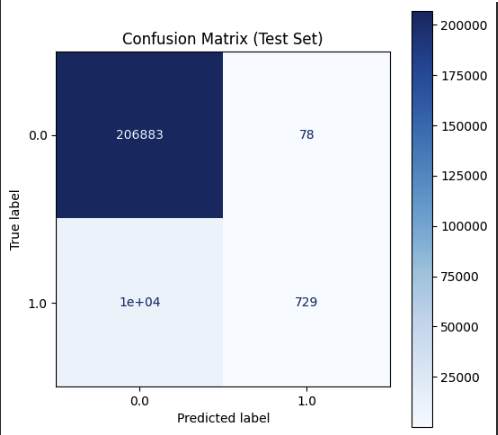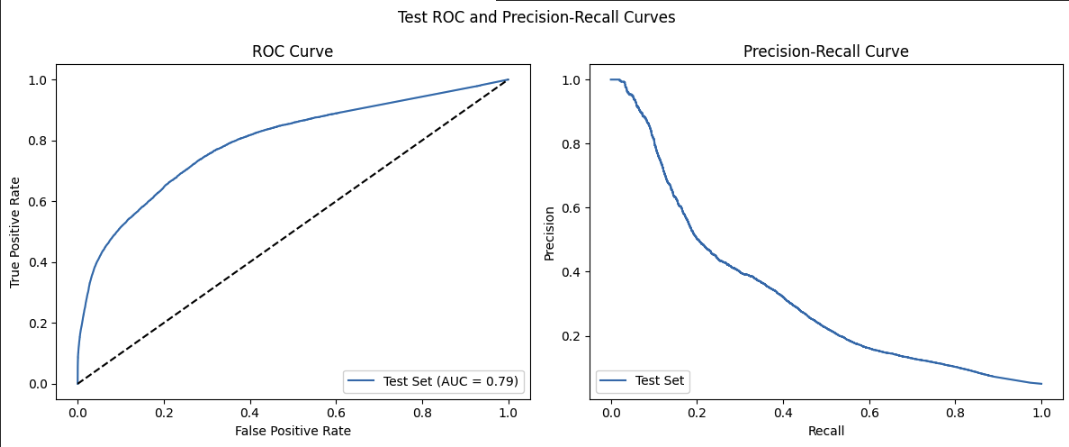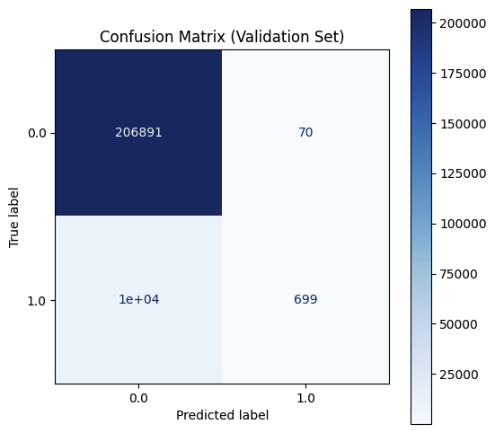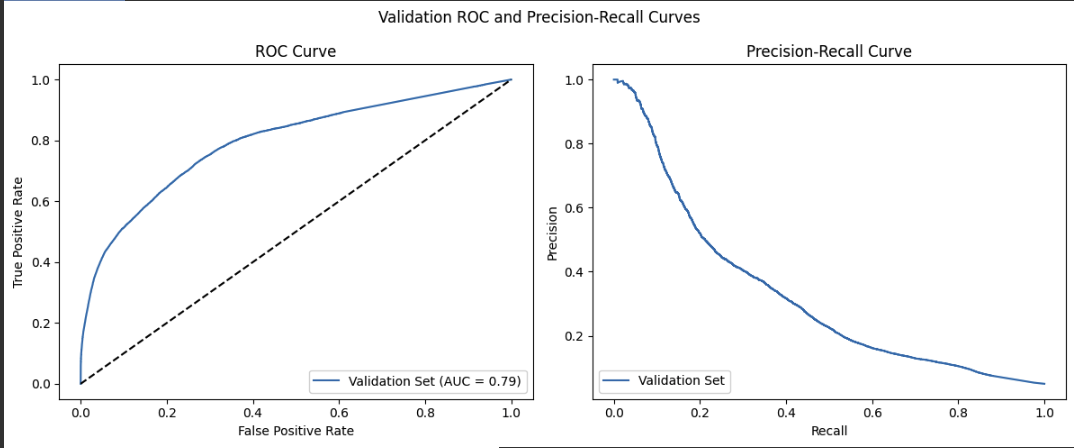

Provides a detailed textual classification report, confusion matrices, and combined plots of ROC and Precision-Recall curves for validation and test sets, focusing on class-level performance analysis.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve

# validation metrics
val_probs = best_model(X_val).detach().numpy()
val_preds = (val_probs > 0.5).astype(int)

print("Validation Classification Report:")
print(classification_report(y_val.numpy(), val_preds))
print("Validation Confusion Matrix:")
val_cm = confusion_matrix(y_val.numpy(), val_preds)
print(val_cm)

val_roc_auc = roc_auc_score(y_val.numpy(), val_probs)
print(f"Validation ROC AUC Score: {val_roc_auc}")

# test metrics
test_probs = best_model(X_test).detach().numpy()
test_preds = (test_probs > 0.5).astype(int)

print("\nTest Classification Report:")
print(classification_report(y_test.numpy(), test_preds))
print("Test Confusion Matrix:")
test_cm = confusion_matrix(y_test.numpy(), test_preds)
print(test_cm)

test_roc_auc = roc_auc_score(y_test.numpy(), test_probs)
print(f"Test ROC AUC Score: {test_roc_auc}")

# plot ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# validation set
plot_roc_curve(axes[0, 0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[0, 1], y_val.numpy(), val_probs, "Validation Set")
axes[0, 0].set_title("Validation ROC Curve")
axes[0, 1].set_title("Validation Precision-Recall Curve")

# test set
plot_roc_curve(axes[1, 0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1, 1], y_test.numpy(), test_probs, "Test Set")
axes[1, 0].set_title("Test ROC Curve")
axes[1, 1].set_title("Test Precision-Recall Curve")

plt.tight_layout()
plt.show()

# plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=axes[0], cmap="Blues")
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=axes[1], cmap="Blues")
axes[1].set_title("Test Confusion Matrix")
plt.show()

Output of the code:

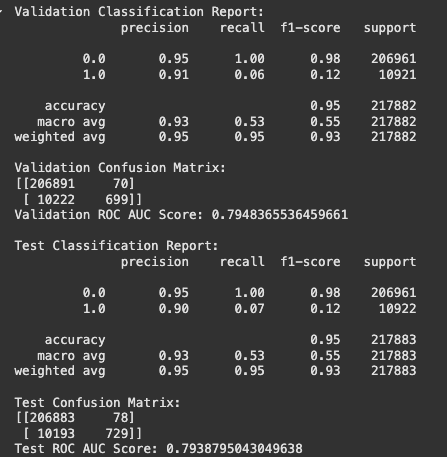
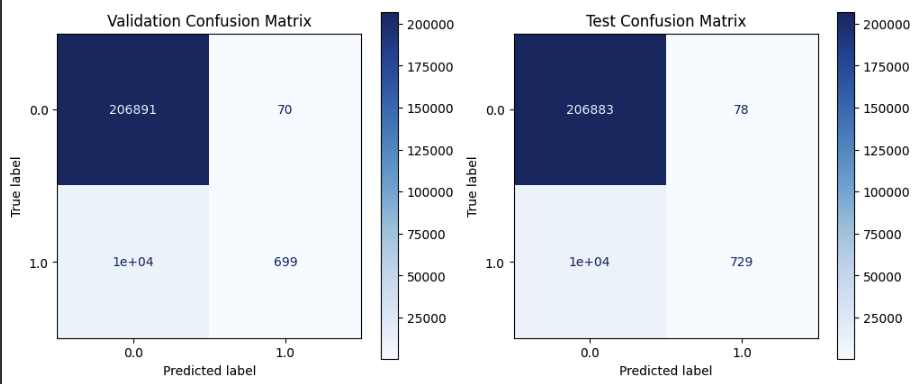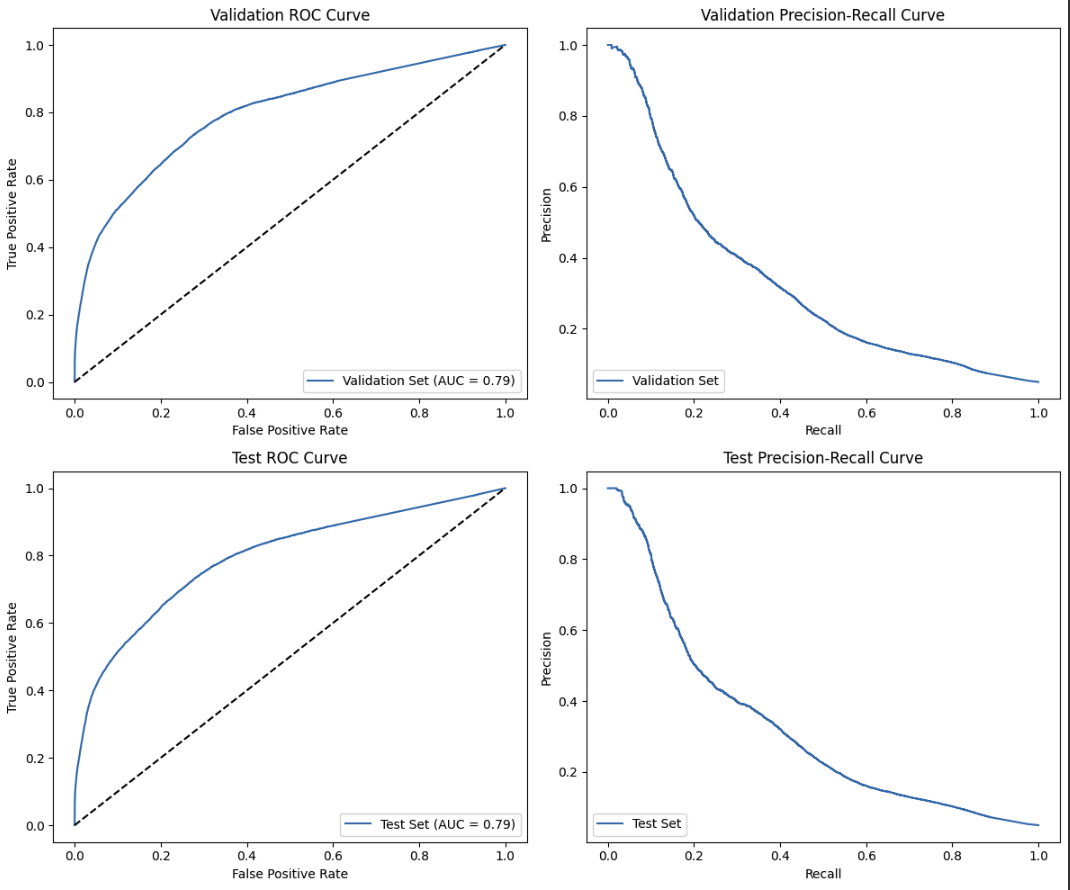

#### Similar to the first, but replaces BCELoss with Focal Loss to address class imbalance by focusing on harder-to-classify samples.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import optuna

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# define focal loss func
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(min=1e-6, max=1 - 1e-6) 
        targets = targets.float()

        loss = -self.alpha * (1 - probs) ** self.gamma * targets * torch.log(probs) - \
               (1 - self.alpha) * probs ** self.gamma * (1 - targets) * torch.log(1 - probs)

        return loss.mean()

# define pytorch model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        # add hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        # add output layer (no sigmoid here)
        layers.append(nn.Linear(current_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)  # output raw logits

# objective function for optuna
def objective(trial):
    # hyperparameters to tune
    hidden_layers = trial.suggest_int("hidden_layers", 2, 4)
    units_per_layer = trial.suggest_int("units_per_layer", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # init model
    input_dim = X_train.shape[1]
    model = FraudNet(input_dim, hidden_layers, units_per_layer, dropout_rate)
    criterion = FocalLoss(alpha=0.25, gamma=2)  # Use Focal Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # DataLoader for batching
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(10):  
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            logits = model(batch_X)  # get raw logits
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), torch.sigmoid(val_logits).numpy())  # Use Sigmoid here for AUC

    # Return validation AUC as the objective to optimize
    return val_auc

# hyperparameter tuning with optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# train best model with auc tracking and focal loss
best_model = FraudNet(
    input_dim=X_train.shape[1],
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

train_aucs = []
val_aucs = []

best_model.train()
for epoch in range(10):  
    y_train_true = []
    y_train_pred = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = best_model(batch_X)  # raw logits
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        # store true and predicted values for auc calculation
        y_train_true.extend(batch_y.numpy())
        y_train_pred.extend(torch.sigmoid(logits).detach().numpy())  # convert logits to probabilities

    # calculate training auc
    train_auc = roc_auc_score(y_train_true, y_train_pred)
    train_aucs.append(train_auc)

    # validation AUC
    best_model.eval()
    with torch.no_grad():
        val_logits = best_model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), torch.sigmoid(val_logits).numpy())
        val_aucs.append(val_auc)

    best_model.train()  # switch back to training mode

    print(f"Epoch {epoch + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# evaluate on test Set
best_model.eval()
with torch.no_grad():
    test_logits = best_model(X_test).numpy()
    test_probs = torch.sigmoid(torch.tensor(test_logits)).numpy()  # Convert logits to probabilities
    test_auc = roc_auc_score(y_test.numpy(), test_probs)
    print(f"Test AUC: {test_auc:.4f}")

# Output of code:
# [I 2024-11-19 08:57:04,885] A new study created in memory with name: no-name-8736ccbf-694b-445e-840a-21015255db83
# [I 2024-11-19 09:30:39,270] Trial 0 finished with value: 0.8051449819655938 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001178448548316156, 'weight_decay': 0.00031993165323804766, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
# [I 2024-11-19 10:08:54,674] Trial 1 finished with value: 0.7898810837611155 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.3, 'learning_rate': 0.003514002864868591, 'weight_decay': 0.00013996389185492281, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
# [I 2024-11-19 10:18:57,213] Trial 2 finished with value: 0.8063415020860077 and parameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 10:47:57,376] Trial 3 finished with value: 0.5 and parameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.008310105471163799, 'weight_decay': 0.0005238785202777933, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 11:10:45,832] Trial 4 finished with value: 0.8020924440709613 and parameters: {'hidden_layers': 2, 'units_per_layer': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001490610809112082, 'weight_decay': 0.00038859247750204625, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 11:29:49,701] Trial 5 finished with value: 0.5 and parameters: {'hidden_layers': 3, 'units_per_layer': 32, 'dropout_rate': 0.3, 'learning_rate': 0.009967884253869408, 'weight_decay': 0.0006259190631157118, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 11:54:04,641] Trial 6 finished with value: 0.5 and parameters: {'hidden_layers': 2, 'units_per_layer': 192, 'dropout_rate': 0.1, 'learning_rate': 0.00881778183966094, 'weight_decay': 0.0005425606083150317, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 12:15:29,259] Trial 7 finished with value: 0.7956594353169826 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.005996790214089131, 'weight_decay': 0.0001251018505924539, 'batch_size': 64}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 13:16:20,006] Trial 8 finished with value: 0.7980007025250819 and parameters: {'hidden_layers': 4, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0014251172904500553, 'weight_decay': 0.0004647577182774816, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 13:30:41,716] Trial 9 finished with value: 0.7708628835676274 and parameters: {'hidden_layers': 2, 'units_per_layer': 160, 'dropout_rate': 0.2, 'learning_rate': 0.005565659358383948, 'weight_decay': 0.0005055561731936407, 'batch_size': 64}. Best is trial 2 with value: 0.8063415020860077.
# Best Hyperparameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}
# Epoch 1: Train AUC = 0.7874, Validation AUC = 0.8016
# Epoch 2: Train AUC = 0.7903, Validation AUC = 0.8040
# Epoch 3: Train AUC = 0.7911, Validation AUC = 0.8028
# Epoch 4: Train AUC = 0.7919, Validation AUC = 0.8019
# Epoch 5: Train AUC = 0.7920, Validation AUC = 0.8055
# Epoch 6: Train AUC = 0.7918, Validation AUC = 0.7985
# Epoch 7: Train AUC = 0.7909, Validation AUC = 0.8019
# Epoch 8: Train AUC = 0.7904, Validation AUC = 0.8005
# Epoch 9: Train AUC = 0.7912, Validation AUC = 0.8023
# Epoch 10: Train AUC = 0.7916, Validation AUC = 0.8051
# Test AUC: 0.8029

[I 2024-11-19 08:57:04,885] A new study created in memory with name: no-name-8736ccbf-694b-445e-840a-21015255db83
[I 2024-11-19 09:30:39,270] Trial 0 finished with value: 0.8051449819655938 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001178448548316156, 'weight_decay': 0.00031993165323804766, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
[I 2024-11-19 10:08:54,674] Trial 1 finished with value: 0.7898810837611155 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.3, 'learning_rate': 0.003514002864868591, 'weight_decay': 0.00013996389185492281, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
[I 2024-11-19 10:18:57,213] Trial 2 finished with value: 0.8063415020860077 and parameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}. Best is trial 2 with va

Best Hyperparameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}
Epoch 1: Train AUC = 0.7874, Validation AUC = 0.8016
Epoch 2: Train AUC = 0.7903, Validation AUC = 0.8040
Epoch 3: Train AUC = 0.7911, Validation AUC = 0.8028
Epoch 4: Train AUC = 0.7919, Validation AUC = 0.8019
Epoch 5: Train AUC = 0.7920, Validation AUC = 0.8055
Epoch 6: Train AUC = 0.7918, Validation AUC = 0.7985
Epoch 7: Train AUC = 0.7909, Validation AUC = 0.8019
Epoch 8: Train AUC = 0.7904, Validation AUC = 0.8005
Epoch 9: Train AUC = 0.7912, Validation AUC = 0.8023
Epoch 10: Train AUC = 0.7916, Validation AUC = 0.8051
Test AUC: 0.8029


Evaluates and visualizes the model's performance with overall metrics (AUC, Precision, Recall, F1), ROC and Precision-Recall curves, and confusion matrices for both validation and test sets.

Validation Set Metrics:
AUC: 0.8051
Precision: 1.0000
Recall: 0.0137
F1 Score: 0.0271

Test Set Metrics:
AUC: 0.8029
Precision: 1.0000
Recall: 0.0141
F1 Score: 0.0278


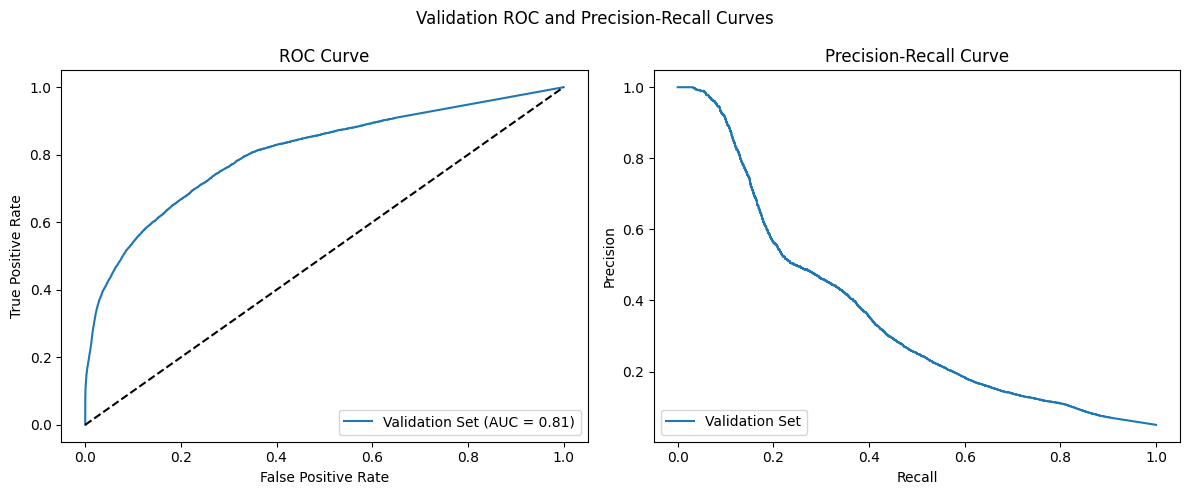

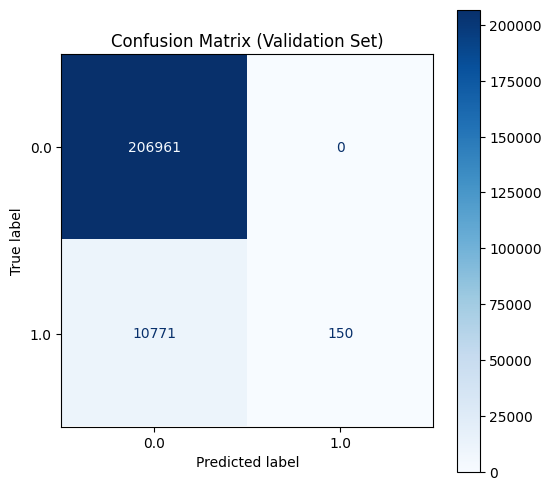

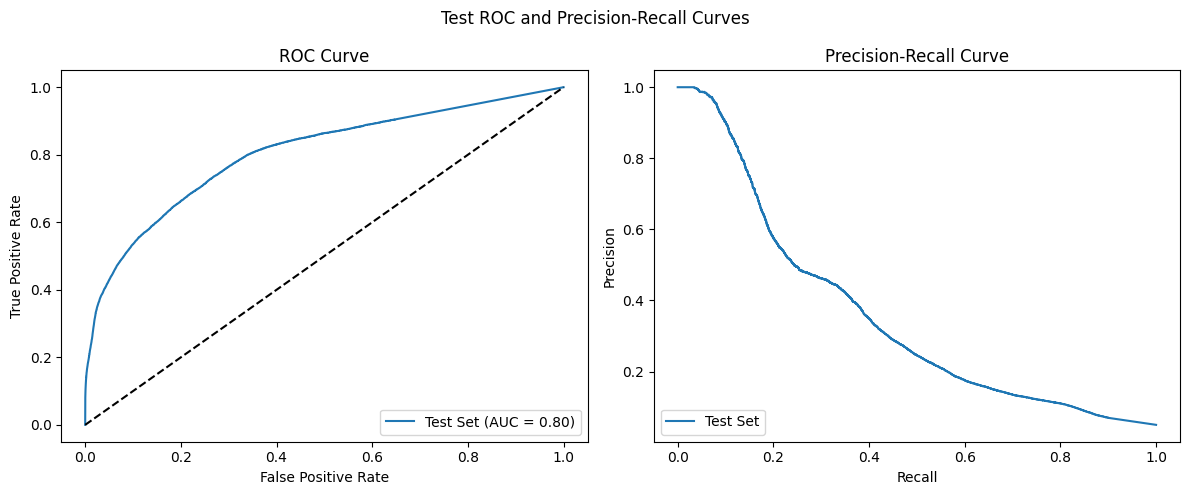

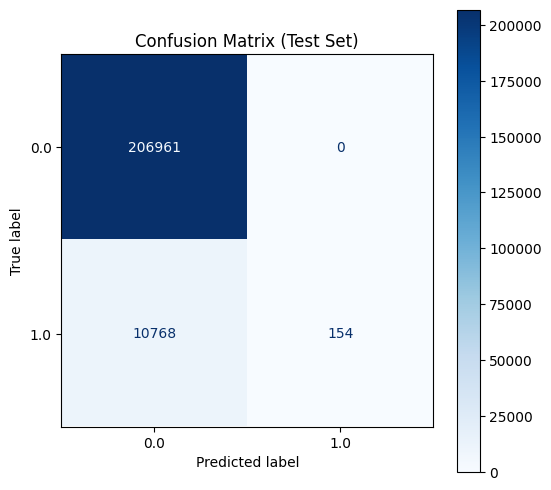

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# metrics for validation set
val_probs = best_model(X_val).detach().numpy()  # predicted probabilities
val_preds = (val_probs > 0.5).astype(int)  # predicted labels

val_auc = roc_auc_score(y_val.numpy(), val_probs)
val_precision = precision_score(y_val.numpy(), val_preds)
val_recall = recall_score(y_val.numpy(), val_preds)
val_f1 = f1_score(y_val.numpy(), val_preds)

print("Validation Set Metrics:")
print(f"AUC: {val_auc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# metrics for test set
test_probs = best_model(X_test).detach().numpy()  # predicted probabilities
test_preds = (test_probs > 0.5).astype(int)  # predicted labels

test_auc = roc_auc_score(y_test.numpy(), test_probs)
test_precision = precision_score(y_test.numpy(), test_preds)
test_recall = recall_score(y_test.numpy(), test_preds)
test_f1 = f1_score(y_test.numpy(), test_preds)

print("\nTest Set Metrics:")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# plotting ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--') 
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

# validation plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[1], y_val.numpy(), val_probs, "Validation Set")
plt.suptitle("Validation ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# confusion matrix for validation set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Validation Set)")
plt.show()

# test plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1], y_test.numpy(), test_probs, "Test Set")
plt.suptitle("Test ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# confusion matrix for test set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test Set)")
plt.show()


Provides a detailed textual classification report, confusion matrices, and combined plots of ROC and Precision-Recall curves for validation and test sets, focusing on class-level performance analysis.

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    206961
         1.0       1.00      0.01      0.03     10921

    accuracy                           0.95    217882
   macro avg       0.98      0.51      0.50    217882
weighted avg       0.95      0.95      0.93    217882

Validation Confusion Matrix:
[[206961      0]
 [ 10771    150]]
Validation ROC AUC Score: 0.805115644348775

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    206961
         1.0       1.00      0.01      0.03     10922

    accuracy                           0.95    217883
   macro avg       0.98      0.51      0.50    217883
weighted avg       0.95      0.95      0.93    217883

Test Confusion Matrix:
[[206961      0]
 [ 10768    154]]
Test ROC AUC Score: 0.8028887300452274


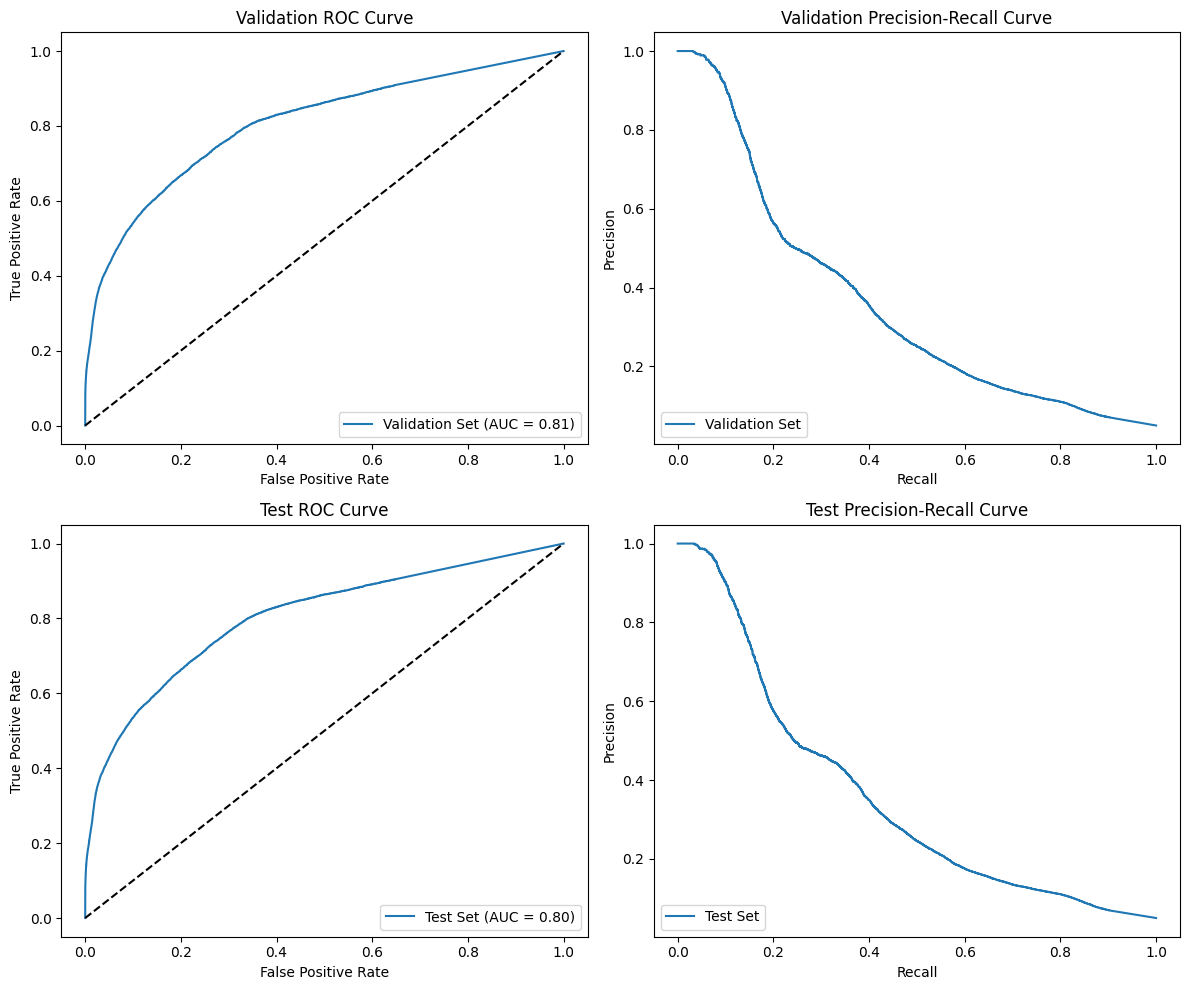

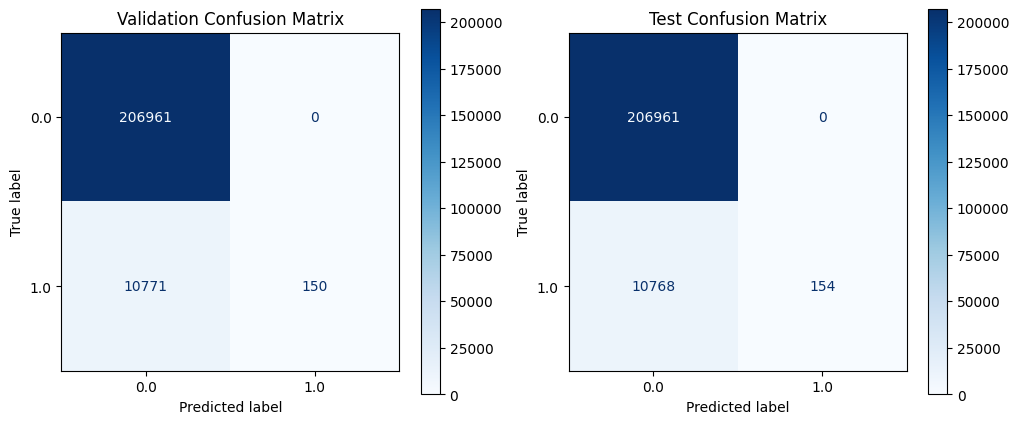

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve

# validation metrics
val_probs = best_model(X_val).detach().numpy()
val_preds = (val_probs > 0.5).astype(int)

print("Validation Classification Report:")
print(classification_report(y_val.numpy(), val_preds))
print("Validation Confusion Matrix:")
val_cm = confusion_matrix(y_val.numpy(), val_preds)
print(val_cm)

val_roc_auc = roc_auc_score(y_val.numpy(), val_probs)
print(f"Validation ROC AUC Score: {val_roc_auc}")

# test Metrics
test_probs = best_model(X_test).detach().numpy()
test_preds = (test_probs > 0.5).astype(int)

print("\nTest Classification Report:")
print(classification_report(y_test.numpy(), test_preds))
print("Test Confusion Matrix:")
test_cm = confusion_matrix(y_test.numpy(), test_preds)
print(test_cm)

test_roc_auc = roc_auc_score(y_test.numpy(), test_probs)
print(f"Test ROC AUC Score: {test_roc_auc}")

# Plot ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# validation set
plot_roc_curve(axes[0, 0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[0, 1], y_val.numpy(), val_probs, "Validation Set")
axes[0, 0].set_title("Validation ROC Curve")
axes[0, 1].set_title("Validation Precision-Recall Curve")

# test set
plot_roc_curve(axes[1, 0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1, 1], y_test.numpy(), test_probs, "Test Set")
axes[1, 0].set_title("Test ROC Curve")
axes[1, 1].set_title("Test Precision-Recall Curve")

plt.tight_layout()
plt.show()

# plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=axes[0], cmap="Blues")
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=axes[1], cmap="Blues")
axes[1].set_title("Test Confusion Matrix")
plt.show()


#### Testing oversampling with BCE Loss (GAN)

Randomly sampling 50% of the oversampled data for efficiency purposes

In [ ]:
# concatenate the GAN-oversampled features and target to form a complete dataset
oversampled_data_GAN = pd.concat([X_train_oversampled_GAN, y_train_oversampled_GAN], axis=1)

# separate fraud and non-fraud cases
fraud_cases_GAN = oversampled_data_GAN[oversampled_data_GAN['Is Fraudulent'] == 1]
non_fraud_cases_GAN = oversampled_data_GAN[oversampled_data_GAN['Is Fraudulent'] == 0]

# sample 50% of fraud and non-fraud cases separately
fraud_sample_GAN = fraud_cases_GAN.sample(frac=0.5, random_state=42)
non_fraud_sample_GAN = non_fraud_cases_GAN.sample(frac=0.5, random_state=42)

# combine the sampled fraud and non-fraud cases to create a balanced subset
subset_data_GAN = pd.concat([fraud_sample_GAN, non_fraud_sample_GAN])

# shuffle the subset to mix fraud and non-fraud cases
subset_data_GAN = subset_data_GAN.sample(frac=1, random_state=42).reset_index(drop=True)

# separate the features and target in the subset
X_subset_GAN = subset_data_GAN.drop(columns=['Is Fraudulent'])  
y_subset_GAN = subset_data_GAN['Is Fraudulent'] 

print("Subset distribution of target variable:")
print(y_subset_GAN.value_counts(normalize=True))

print(f"Subset size: {len(X_subset_GAN)}")


Subset distribution of target variable:
Is Fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64
Subset size: 965816


In [ ]:
# convert the subset data to PyTorch tensors
X_subset_GAN = torch.tensor(X_subset_GAN.values, dtype=torch.float32)
y_subset_GAN = torch.tensor(y_subset_GAN.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# pytorch model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# objective function for optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_layers = trial.suggest_int("hidden_layers", 2, 4)
    units_per_layer = trial.suggest_int("units_per_layer", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # init model
    input_dim = X_subset_GAN.shape[1]
    model = FraudNet(input_dim, hidden_layers, units_per_layer, dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # dataLoader for batching
    subset_dataset = torch.utils.data.TensorDataset(X_subset_GAN, y_subset_GAN)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(10):
        for batch_X, batch_y in subset_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy()) 

    # return val auc as objective to optimize
    return val_auc

# hyperparameter tuning with optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# train best model with subset
input_dim = X_subset_GAN.shape[1]
best_model = FraudNet(
    input_dim=input_dim,
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

subset_dataset = torch.utils.data.TensorDataset(X_subset_GAN, y_subset_GAN)
subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=best_params["batch_size"], shuffle=True)

train_aucs = []
val_aucs = []

best_model.train()
for epoch in range(10): 
    y_subset_true = []
    y_subset_pred = []

    for batch_X, batch_y in subset_loader:
        optimizer.zero_grad()
        outputs = best_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        y_subset_true.extend(batch_y.numpy())
        y_subset_pred.extend(outputs.detach().numpy())

    # calculate training auc
    train_auc = roc_auc_score(y_subset_true, y_subset_pred)
    train_aucs.append(train_auc)

    # val auc
    best_model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())
        val_aucs.append(val_auc)

    best_model.train()  

    print(f"Epoch {epoch + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# evaluate on test set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test).numpy()
    test_auc = roc_auc_score(y_test.numpy(), test_outputs)
    print(f"Test AUC: {test_auc:.4f}")

[I 2024-11-20 05:14:24,166] A new study created in memory with name: no-name-d1c9fa78-6100-4204-a71e-95f0481d4a70
[I 2024-11-20 05:54:26,171] Trial 0 finished with value: 0.8070511928386 and parameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0010237200001350808, 'weight_decay': 0.0007499441014853431, 'batch_size': 32}. Best is trial 0 with value: 0.8070511928386.
[I 2024-11-20 06:05:12,875] Trial 1 finished with value: 0.7921458708401455 and parameters: {'hidden_layers': 3, 'units_per_layer': 64, 'dropout_rate': 0.2, 'learning_rate': 0.004300489293938834, 'weight_decay': 0.00015990738416467125, 'batch_size': 64}. Best is trial 0 with value: 0.8070511928386.
[I 2024-11-20 06:30:31,617] Trial 2 finished with value: 0.7757805516194105 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.009561049087312628, 'weight_decay': 0.0002595346517751548, 'batch_size': 32}. Best is trial 0 with value: 0.807

Best Hyperparameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0010237200001350808, 'weight_decay': 0.0007499441014853431, 'batch_size': 32}
Epoch 1: Train AUC = 0.9880, Validation AUC = 0.8086
Epoch 2: Train AUC = 0.9884, Validation AUC = 0.8107
Epoch 3: Train AUC = 0.9885, Validation AUC = 0.8057
Epoch 4: Train AUC = 0.9884, Validation AUC = 0.8055
Epoch 5: Train AUC = 0.9886, Validation AUC = 0.8038
Epoch 6: Train AUC = 0.9885, Validation AUC = 0.8081
Epoch 7: Train AUC = 0.9886, Validation AUC = 0.8094
Epoch 8: Train AUC = 0.9891, Validation AUC = 0.7813
Epoch 9: Train AUC = 0.9896, Validation AUC = 0.7932
Epoch 10: Train AUC = 0.9898, Validation AUC = 0.7841
Test AUC: 0.7830


Validation Set Metrics:
AUC: 0.7841
Precision: 0.7473
Recall: 0.1497
F1 Score: 0.2494

Test Set Metrics:
AUC: 0.7830
Precision: 0.7443
Recall: 0.1530
F1 Score: 0.2538


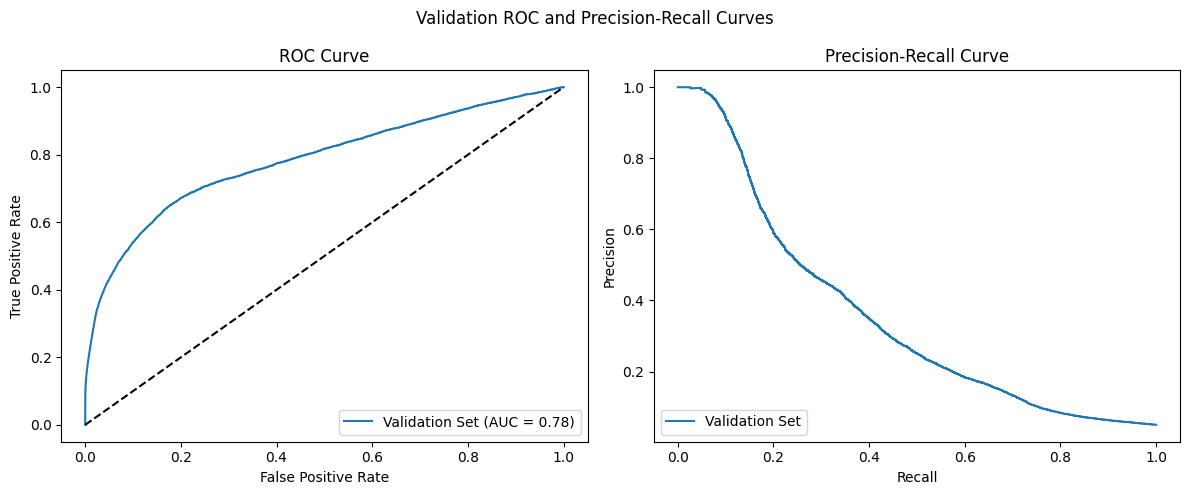

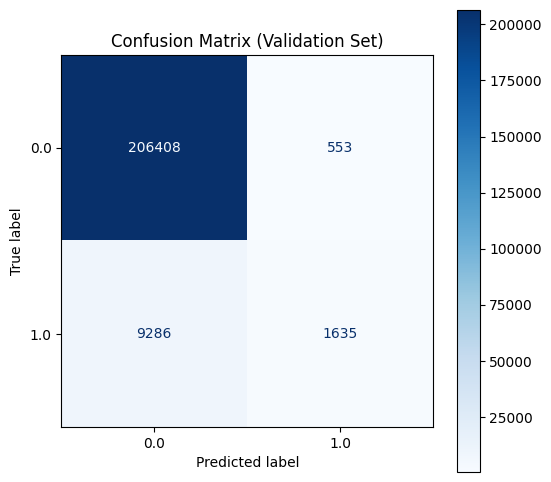

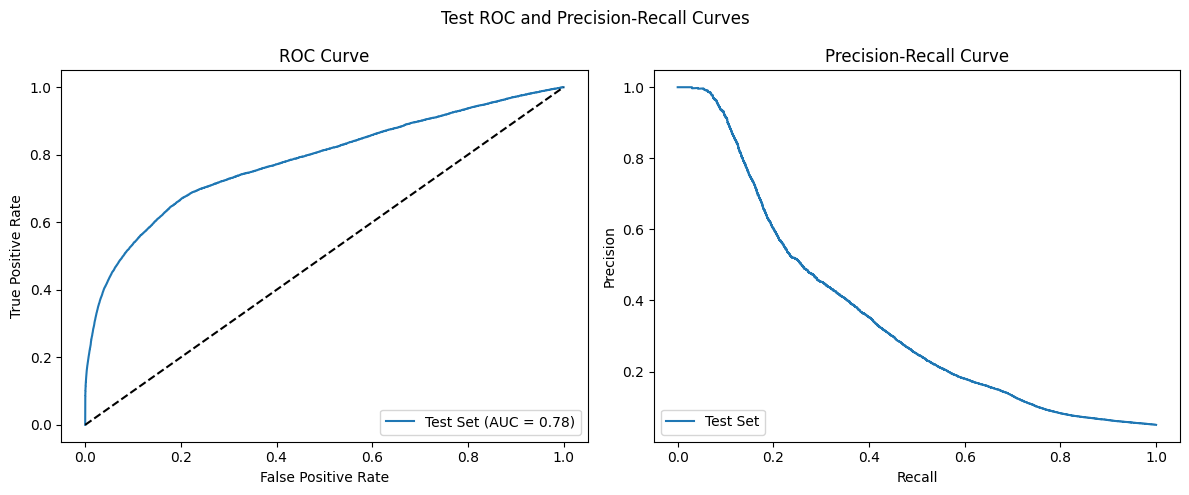

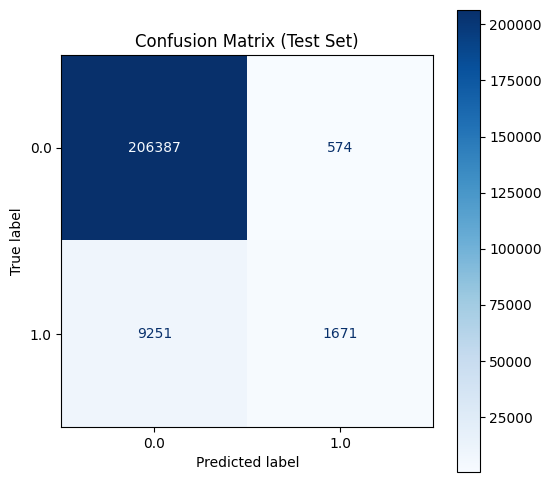

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# metrics for val set
val_probs = best_model(X_val).detach().numpy() 
val_preds = (val_probs > 0.5).astype(int)  

val_auc = roc_auc_score(y_val.numpy(), val_probs)
val_precision = precision_score(y_val.numpy(), val_preds)
val_recall = recall_score(y_val.numpy(), val_preds)
val_f1 = f1_score(y_val.numpy(), val_preds)

print("Validation Set Metrics:")
print(f"AUC: {val_auc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# metrics for test set
test_probs = best_model(X_test).detach().numpy()  
test_preds = (test_probs > 0.5).astype(int) 

test_auc = roc_auc_score(y_test.numpy(), test_probs)
test_precision = precision_score(y_test.numpy(), test_preds)
test_recall = recall_score(y_test.numpy(), test_preds)
test_f1 = f1_score(y_test.numpy(), test_preds)

print("\nTest Set Metrics:")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plotting ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

# validation plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[1], y_val.numpy(), val_probs, "Validation Set")
plt.suptitle("Validation ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# confusion matrix for validation set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Validation Set)")
plt.show()

# test plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1], y_test.numpy(), test_probs, "Test Set")
plt.suptitle("Test ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# confusion matrix for test set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test Set)")
plt.show()


Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    206961
         1.0       0.75      0.15      0.25     10921

    accuracy                           0.95    217882
   macro avg       0.85      0.57      0.61    217882
weighted avg       0.95      0.95      0.94    217882

Validation Confusion Matrix:
[[206408    553]
 [  9286   1635]]
Validation ROC AUC Score: 0.7840949402683675

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    206961
         1.0       0.74      0.15      0.25     10922

    accuracy                           0.95    217883
   macro avg       0.85      0.58      0.62    217883
weighted avg       0.95      0.95      0.94    217883

Test Confusion Matrix:
[[206387    574]
 [  9251   1671]]
Test ROC AUC Score: 0.782958127892487


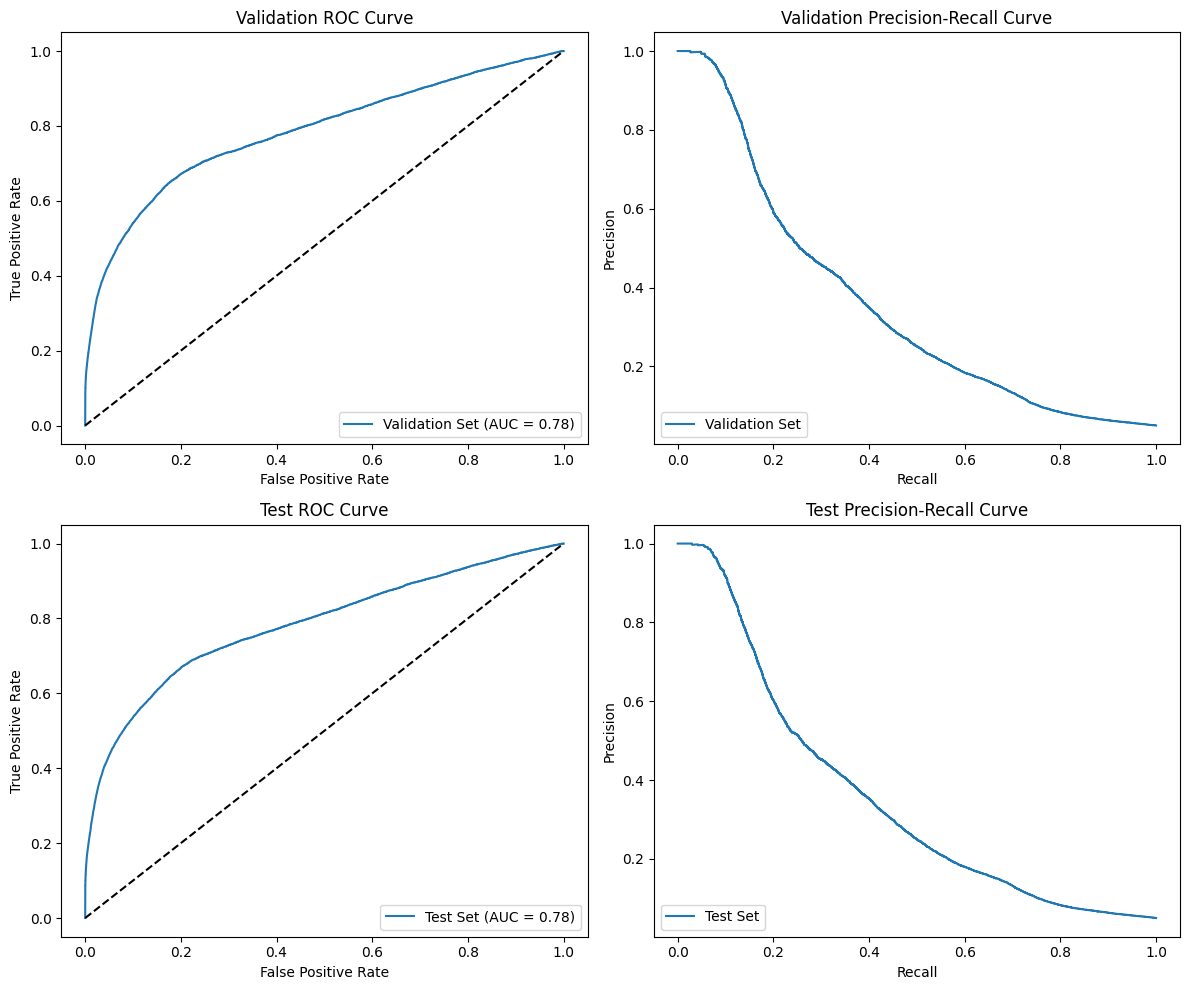

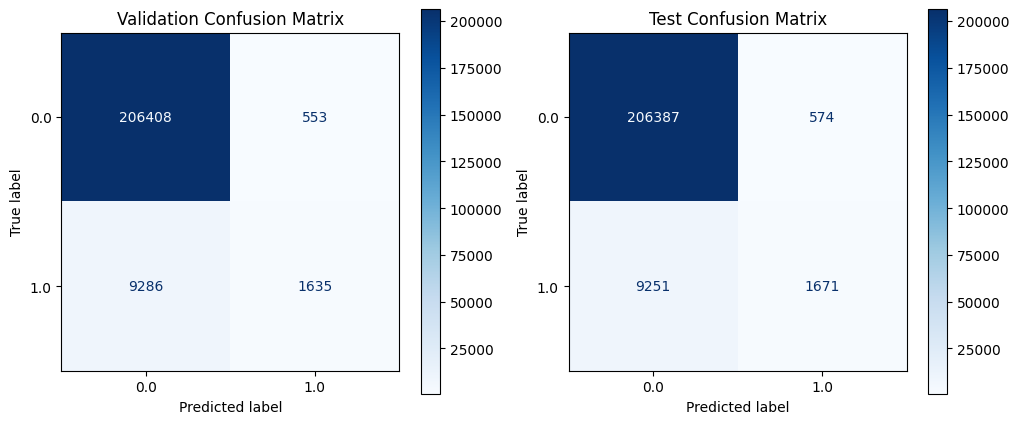

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve

# validation metrics
val_probs = best_model(X_val).detach().numpy()
val_preds = (val_probs > 0.5).astype(int)

print("Validation Classification Report:")
print(classification_report(y_val.numpy(), val_preds))
print("Validation Confusion Matrix:")
val_cm = confusion_matrix(y_val.numpy(), val_preds)
print(val_cm)

val_roc_auc = roc_auc_score(y_val.numpy(), val_probs)
print(f"Validation ROC AUC Score: {val_roc_auc}")

# test metrics
test_probs = best_model(X_test).detach().numpy()
test_preds = (test_probs > 0.5).astype(int)

print("\nTest Classification Report:")
print(classification_report(y_test.numpy(), test_preds))
print("Test Confusion Matrix:")
test_cm = confusion_matrix(y_test.numpy(), test_preds)
print(test_cm)

test_roc_auc = roc_auc_score(y_test.numpy(), test_probs)
print(f"Test ROC AUC Score: {test_roc_auc}")

# plot roc curve
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--') 
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

# plot precision-recall curve
def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# validation set
plot_roc_curve(axes[0, 0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[0, 1], y_val.numpy(), val_probs, "Validation Set")
axes[0, 0].set_title("Validation ROC Curve")
axes[0, 1].set_title("Validation Precision-Recall Curve")

# test set
plot_roc_curve(axes[1, 0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1, 1], y_test.numpy(), test_probs, "Test Set")
axes[1, 0].set_title("Test ROC Curve")
axes[1, 1].set_title("Test Precision-Recall Curve")

plt.tight_layout()
plt.show()

# confusion matrices plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=axes[0], cmap="Blues")
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=axes[1], cmap="Blues")
axes[1].set_title("Test Confusion Matrix")
plt.show()


#### Testing oversampling with BCE Loss (SMOTE)

Randomly sample 10% of oversampled data for efficiency reasons and also computational constraints

In [ ]:
from sklearn.model_selection import train_test_split

# Concatenate the SMOTE oversampled features and target to form a complete dataset
oversampled_data_SMOTE = pd.concat([X_train_oversampled_SMOTE, y_train_oversampled_SMOTE], axis=1)

# Separate fraud and non-fraud cases
fraud_cases_SMOTE = oversampled_data_SMOTE[oversampled_data_SMOTE['Is Fraudulent'] == 1]
non_fraud_cases_SMOTE = oversampled_data_SMOTE[oversampled_data_SMOTE['Is Fraudulent'] == 0]

# Sample 10% of fraud and non-fraud cases separately
fraud_sample_SMOTE = fraud_cases_SMOTE.sample(frac=0.1, random_state=42)
non_fraud_sample_SMOTE = non_fraud_cases_SMOTE.sample(frac=0.1, random_state=42)

subset_data_SMOTE = pd.concat([fraud_sample_SMOTE, non_fraud_sample_SMOTE])

# Shuffle the subset to mix fraud and non-fraud cases
subset_data_SMOTE = subset_data_SMOTE.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the features and target in the subset
X_subset_SMOTE = subset_data_SMOTE.drop(columns=['Is Fraudulent'])  
y_subset_SMOTE = subset_data_SMOTE['Is Fraudulent'] 

print("Subset distribution of target variable:")
print(y_subset_SMOTE.value_counts(normalize=True))

print(f"Subset size: {len(X_subset_SMOTE)}")

Output of the code: <Br>
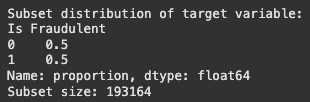

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import optuna

# convert the SMOTE subset data to PyTorch tensors
X_subset_SMOTE = torch.tensor(X_subset_SMOTE.values, dtype=torch.float32)
y_subset_SMOTE = torch.tensor(y_subset_SMOTE.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# pytorch model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# objective function for optuna
def objective(trial):
    # hyperparameters to tune
    hidden_layers = trial.suggest_int("hidden_layers", 2, 4)
    units_per_layer = trial.suggest_int("units_per_layer", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # init model
    input_dim = X_subset_SMOTE.shape[1]
    model = FraudNet(input_dim, hidden_layers, units_per_layer, dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # dataloader for batching
    subset_dataset = torch.utils.data.TensorDataset(X_subset_SMOTE, y_subset_SMOTE)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(10): 
        for batch_X, batch_y in subset_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())  # Calculate validation AUC

    # return val auc as objective to optimize
    return val_auc

# hyperparameter tuning with optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# train best model with subset
input_dim = X_subset_SMOTE.shape[1]
best_model = FraudNet(
    input_dim=input_dim,
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

subset_dataset = torch.utils.data.TensorDataset(X_subset_SMOTE, y_subset_SMOTE)
subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=best_params["batch_size"], shuffle=True)

train_aucs = []
val_aucs = []

best_model.train()
for epoch in range(10): 
    y_subset_true = []
    y_subset_pred = []

    for batch_X, batch_y in subset_loader:
        optimizer.zero_grad()
        outputs = best_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        y_subset_true.extend(batch_y.numpy())
        y_subset_pred.extend(outputs.detach().numpy())

    # calculate training auc
    train_auc = roc_auc_score(y_subset_true, y_subset_pred)
    train_aucs.append(train_auc)

    # validation auc
    best_model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())
        val_aucs.append(val_auc)

    best_model.train()  

    print(f"Epoch {epoch + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# evaluate on test set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test).numpy()
    test_auc = roc_auc_score(y_test.numpy(), test_outputs)
    print(f"Test AUC: {test_auc:.4f}")


# [I 2024-11-19 15:10:41,412] A new study created in memory with name: no-name-b586fa80-2511-40fb-8e6c-9cf5f626b128
# [I 2024-11-19 15:15:39,335] Trial 0 finished with value: 0.7704427182537192 and parameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.007818041348539879, 'weight_decay': 0.00015242215442193556, 'batch_size': 32}. Best is trial 0 with value: 0.7704427182537192.
# [I 2024-11-19 15:23:58,032] Trial 1 finished with value: 0.760162620790988 and parameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0033359065458614056, 'weight_decay': 0.00011713834257558934, 'batch_size': 32}. Best is trial 0 with value: 0.7704427182537192.
# [I 2024-11-19 15:28:59,392] Trial 2 finished with value: 0.7672012857843087 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001169751111374578, 'weight_decay': 0.0002136731583674963, 'batch_size': 32}. Best is trial 0 with value: 0.7704427182537192.
# [I 2024-11-19 15:31:31,306] Trial 3 finished with value: 0.7730354212637308 and parameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0021550837915513934, 'weight_decay': 0.0004995392234015692, 'batch_size': 32}. Best is trial 3 with value: 0.7730354212637308.
# [I 2024-11-19 15:37:49,997] Trial 4 finished with value: 0.7659861692529715 and parameters: {'hidden_layers': 3, 'units_per_layer': 192, 'dropout_rate': 0.2, 'learning_rate': 0.002225012685528519, 'weight_decay': 0.00016564862070006273, 'batch_size': 32}. Best is trial 3 with value: 0.7730354212637308.
# [I 2024-11-19 15:39:37,029] Trial 5 finished with value: 0.7724455400298958 and parameters: {'hidden_layers': 2, 'units_per_layer': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001679415983482423, 'weight_decay': 0.000333807866224809, 'batch_size': 64}. Best is trial 3 with value: 0.7730354212637308.
# [I 2024-11-19 15:41:32,121] Trial 6 finished with value: 0.7677219558682631 and parameters: {'hidden_layers': 4, 'units_per_layer': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0013680569849642606, 'weight_decay': 0.0002120654912616767, 'batch_size': 64}. Best is trial 3 with value: 0.7730354212637308.
# [I 2024-11-19 15:43:59,397] Trial 7 finished with value: 0.7686984689706997 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0011965933882067796, 'weight_decay': 0.00010508921498403411, 'batch_size': 64}. Best is trial 3 with value: 0.7730354212637308.
# [I 2024-11-19 15:47:25,062] Trial 8 finished with value: 0.7700328253862525 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.3, 'learning_rate': 0.007398956666048613, 'weight_decay': 0.00032505299213820107, 'batch_size': 64}. Best is trial 3 with value: 0.7730354212637308.
# [I 2024-11-19 15:49:35,600] Trial 9 finished with value: 0.777197037611384 and parameters: {'hidden_layers': 2, 'units_per_layer': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0012603385198312607, 'weight_decay': 0.00035365856785756503, 'batch_size': 64}. Best is trial 9 with value: 0.777197037611384.
# Best Hyperparameters: {'hidden_layers': 2, 'units_per_layer': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0012603385198312607, 'weight_decay': 0.00035365856785756503, 'batch_size': 64}
# Epoch 1: Train AUC = 0.9375, Validation AUC = 0.7687
# Epoch 2: Train AUC = 0.9575, Validation AUC = 0.7685
# Epoch 3: Train AUC = 0.9640, Validation AUC = 0.7702
# Epoch 4: Train AUC = 0.9657, Validation AUC = 0.7749
# Epoch 5: Train AUC = 0.9660, Validation AUC = 0.7762
# Epoch 6: Train AUC = 0.9662, Validation AUC = 0.7724
# Epoch 7: Train AUC = 0.9662, Validation AUC = 0.7747
# Epoch 8: Train AUC = 0.9667, Validation AUC = 0.7610
# Epoch 9: Train AUC = 0.9671, Validation AUC = 0.7711
# Epoch 10: Train AUC = 0.9672, Validation AUC = 0.7646
# Test AUC: 0.7682

#### Since Focal Loss produce the best results, we would choose this variation. <BR>
#### Now, we test out different threshold and see the metrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# define focal loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(min=1e-6, max=1 - 1e-6)  
        targets = targets.float()

        loss = -self.alpha * (1 - probs) ** self.gamma * targets * torch.log(probs) - \
               (1 - self.alpha) * probs ** self.gamma * (1 - targets) * torch.log(1 - probs)

        return loss.mean()

# pytorch model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        layers.append(nn.Linear(current_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)  

#best hyperparameters (manually hardcoded from previous optuna run)
best_params = {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1,
               'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}

# train best model with focal loss
input_dim = X_train.shape[1]
best_model = FraudNet(
    input_dim=input_dim,
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = FocalLoss(alpha=0.25, gamma=2)  # Use Focal Loss
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

best_model.train()
for epoch in range(10):  
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = best_model(batch_X)  
        loss = criterion(logits, batch_y)  # apply focal loss directly
        loss.backward()
        optimizer.step()

# evaluate model with different binary classification thresholds
def evaluate_thresholds(y_true, y_probs, thresholds):
    metrics = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)  # convrt to binary predictions
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_probs)
        conf_matrix = confusion_matrix(y_true, y_pred)
        metrics.append({
            "Threshold": threshold,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Accuracy": accuracy,
            "AUC": auc,
            "Confusion Matrix": conf_matrix
        })
    return metrics

# validation and test probabilities
best_model.eval()
with torch.no_grad():
    val_logits = best_model(X_val)
    val_probs = torch.sigmoid(val_logits).numpy()
    test_logits = best_model(X_test)
    test_probs = torch.sigmoid(test_logits).numpy()

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

# evaluate metrics on validation set
validation_metrics = evaluate_thresholds(y_val.numpy(), val_probs, thresholds)
print("Validation Set Metrics at Different Thresholds:")
for metric in validation_metrics:
    print(f"Threshold: {metric['Threshold']:.2f}")
    print(f"  Precision: {metric['Precision']:.4f}, Recall: {metric['Recall']:.4f}, F1 Score: {metric['F1 Score']:.4f}, Accuracy: {metric['Accuracy']:.4f}, AUC: {metric['AUC']:.4f}")
    print(f"  Confusion Matrix:\n{metric['Confusion Matrix']}")
    print()

# evaluate metrics on test set
test_metrics = evaluate_thresholds(y_test.numpy(), test_probs, thresholds)
print("Test Set Metrics at Different Thresholds:")
for metric in test_metrics:
    print(f"Threshold: {metric['Threshold']:.2f}")
    print(f"  Precision: {metric['Precision']:.4f}, Recall: {metric['Recall']:.4f}, F1 Score: {metric['F1 Score']:.4f}, Accuracy: {metric['Accuracy']:.4f}, AUC: {metric['AUC']:.4f}")
    print(f"  Confusion Matrix:\n{metric['Confusion Matrix']}")
    print()

# plot roc curve
def plot_roc_curve(ax, y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend()

# plot precision-recall curve
def plot_precision_recall_curve(ax, y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend()

# plot for val set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[1], y_val.numpy(), val_probs, "Validation Set")
plt.suptitle("Validation Set ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# plot for test set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1], y_test.numpy(), test_probs, "Test Set")
plt.suptitle("Test Set ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

Output of the code: <Br>
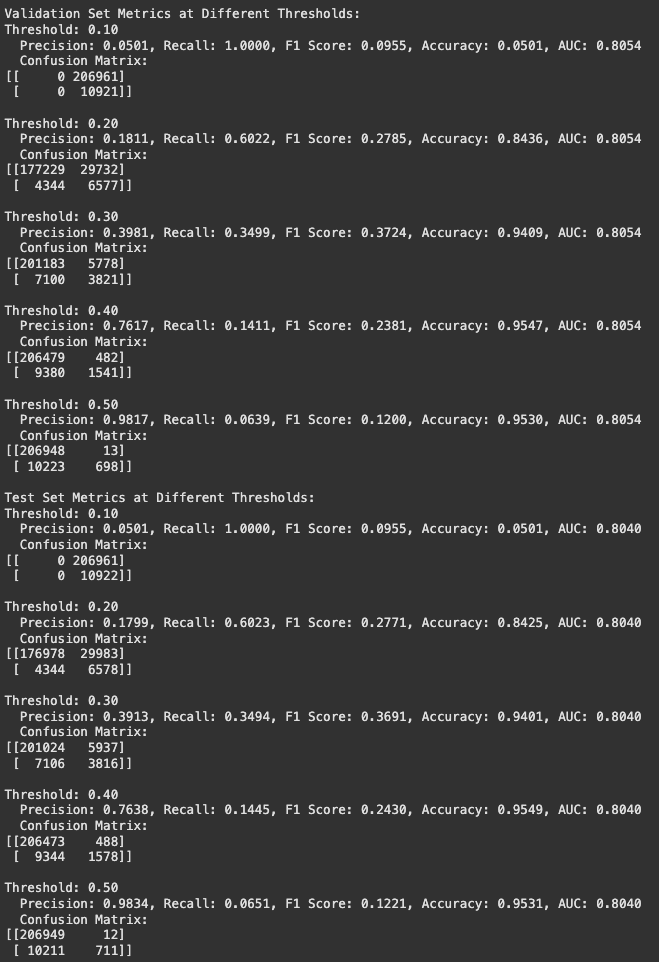
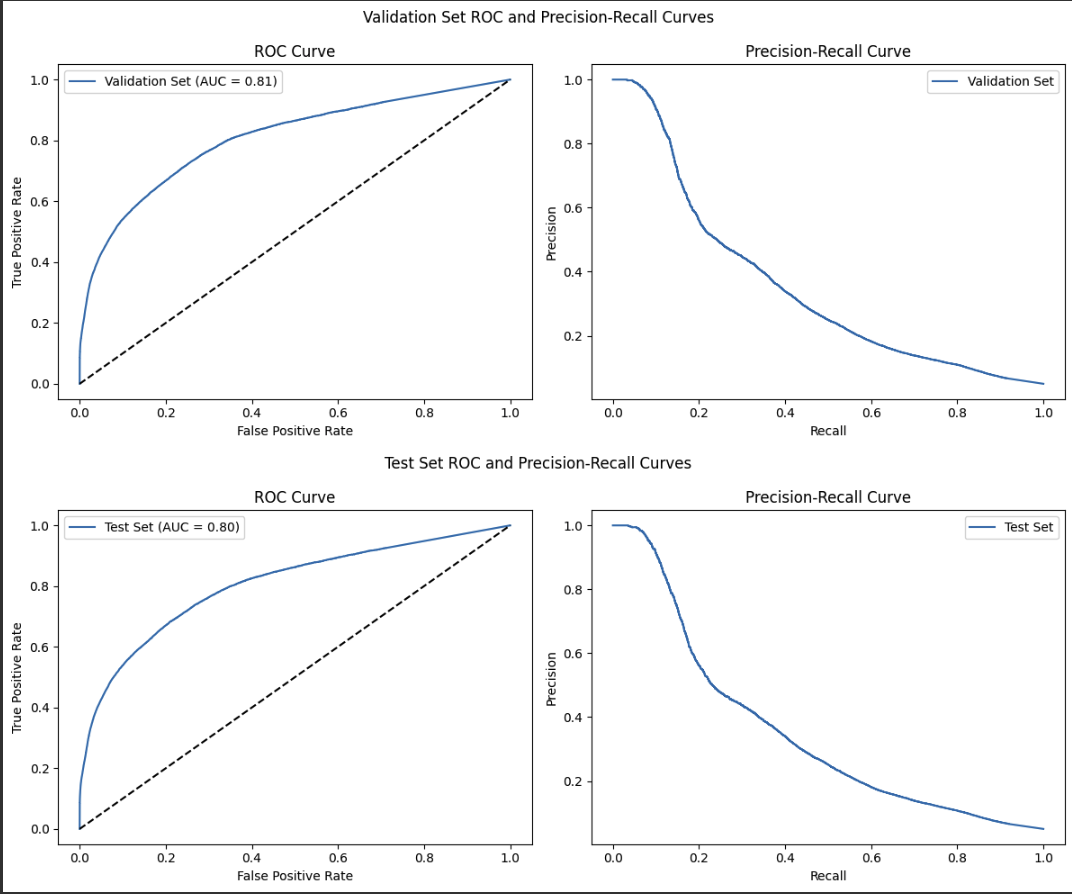